In [16]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 884.0 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os,json
import datetime
from collections import deque
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import utils
import sliding_window

import warnings

warnings.filterwarnings("ignore")
import xgboost as xgb

import datetime, time
import importlib
importlib.reload(sliding_window)

<module 'sliding_window' from '/home/aboughas/online_ppm_stability/expereiment/sliding_window.py'>

In [6]:
def display_progress(row_counting, total_length, interval=2000):
    if rowcounter%interval == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running cases: %s'%(len(streaming_db)))

In [8]:
def update_test_cases(new_case, test_cases):
    test_cases.append(new_case)
    if len(test_cases) > test_size:
        test_cases.popleft()

In [10]:
# Experiment settings
dataset_label = 'bpic17'

# Invoke parameters for dataset
with open('../dataset_parameters.json','r') as json_file:
    parameters = json.load(json_file)[dataset_label]
    print(parameters)
    key_pair = parameters['key_pair']
    catatars = parameters['categorical_attrs']
    maximum_prefixs = parameters['maximum_prefix']

{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Start Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 15}


In [36]:
'''
Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
and obtain feature matrix to transform future events
'''


for maximum_prefix in range(1, maximum_prefixs+1):
    print(maximum_prefix)
    performance_measure_type = 'ROCAUC'
    dataset_loc = '../DATA/logs/'+ dataset_label +'.csv'
    try:
        os.makedirs('../result/%s'%(dataset_label))
    except:
        pass

    # Set streaming classifier
    classifier = 'xgb'
    if classifier == 'xgb':
        streaming_classifier = xgb.XGBClassifier(n_estimators = 100, learning_rate=0.01, verbosity =0)

    streaming_db ={}
    training_models ={}
    test_cases = deque()
    feature_matrix ={}

    casecount = 0
    rowcounter = 0
    running_case = 0
    prediction_result = dict()
    for i in range(1, maximum_prefix+1): prediction_result[i] = {}
    finished_caseid = set()
    
    # Sliding window for training setting
    window_size = 100
    test_size = 30
    training_windows = sliding_window.training_window(window_size,test_size)
    training_models['prefix_%s'%(maximum_prefix)] = [streaming_classifier, 0]
    
    dataset = stream.iter_csv(
            dataset_loc
            )
    totallength = len(list(dataset))

    dataset = stream.iter_csv(
                dataset_loc,
                target='outcome'
                )
    enctype = 'Index-base'
    
    cdhappend ={}
    for i in range(1, maximum_prefix+1): cdhappend[i] = 0

    for x,y in dataset:
        rowcounter +=1
        # Event stream change dictionary keys
        x = utils.dictkey_chg(x, key_pair)

        if dataset_label !='bpic15':
            x['ts'] = x['ts'][:-4]

        x['outcome'] =y 
        # Initialize case by prefix length
        caseid = x['caseid']
        outcome = x['outcome']
    #     progress = x['progress']

        x.pop('caseid')
        x.pop('outcome')

    #     x.pop('progress')

        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(streaming_db.keys()):
            case_bin.set_prefix_length(1)    
            streaming_db[caseid] = []
        elif caseid in finished_caseid:
            pass
        else:
            case_bin.set_prefix_length(len(streaming_db[caseid])+1)
            case_bin.set_prev_enc(streaming_db[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)
        ts = case_bin.event['ts']
        streaming_db[caseid].append(case_bin)
        # Detect label appeared case 
        if outcome != '' and caseid not in finished_caseid:
            for i in streaming_db[caseid]:
                i.update_truelabel(outcome)
            finished_caseid.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1
            # Grace period to collect feature matrix
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(maximum_prefix)]=set()

                case_length = len(streaming_db[caseid])
                if case_length >= maximum_prefix:
                    x = streaming_db[caseid][maximum_prefix-1]
                    training_windows.update_window(x)
                    update_test_cases(streaming_db[caseid], test_cases)

                    if training_windows.retraining_count == test_size:
                        x_training = pd.DataFrame.from_dict([i.encoded for i in training_windows.container])
                        for i in x_training.columns.values: x_training[i] = x_training[i].fillna(0)
                        feature_matrix['prefix_%s'%(maximum_prefix)] = x_training.columns.values
                        y_training = [i.true_label for i in training_windows.container]
                        #print("Unique labels in y_training:", type(y_training))
                        #print("Shape of x_training:", x_training.shape)
                        
                        
                        
                        le = LabelEncoder()
                        y_training = le.fit_transform(y_training)

                        training_models['prefix_%s'%(maximum_prefix)][0].fit(x_training, np.array(y_training))
                        training_models['prefix_%s'%(maximum_prefix)][1] +=1
                        training_windows.reset_retraining_count()

                        '''
                        Evaluate current model with test cases
                        '''
                        model_update_count = training_models['prefix_%s'%(maximum_prefix)][1]
                        prediction_result[maximum_prefix][model_update_count] = {}
                        y_truelist = []
                        y_predlist = []
                        for case in test_cases:
                            if len(case) >= maximum_prefix:
                                x = case[maximum_prefix-1]
                                model = training_models['prefix_%s'%(x.prefix_length)][0]
                                current_event = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                                current_event = pd.Series(current_event).to_frame().T
                                y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba(current_event)
                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)

                        prediction_result[maximum_prefix][model_update_count]['y_true'] = y_truelist
                        prediction_result[maximum_prefix][model_update_count]['y_pred'] = y_predlist
                        if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
                            cdhappend[maximum_prefix] = model_update_count
    for evaluation_method in ['Accuracy', 'F1', 'ROCAUC']:
        prefix = maximum_prefix
        update_count =[]
        evaluation_list = []
        length_list = []
        for update in prediction_result[prefix].keys():
            y_true = prediction_result[prefix][update]['y_true']
            y_pred_prob_ = prediction_result[prefix][update]['y_pred']
            prediction_class = training_models['prefix_%s'%(maximum_prefix)][0].classes_
            if len(prediction_class) == 1: prediction_class = ['False', 'True']
            y_pred_prob = []
            for i in y_pred_prob_:
                y_pred_prob.append({prediction_class[0]: i[0][0], prediction_class[1]: i[0][1]})
            y_pred = [max(x, key=x.get) for x in y_pred_prob]
            update_count.append(update)

            if evaluation_method =='Accuracy':
                value = accuracy_score(y_true, y_pred)
            elif evaluation_method =='F1':
                conv_y_pred = ['True' if pred == 1 else 'False' for pred in y_pred]
                value = f1_score(y_true, conv_y_pred, average='macro')

            elif evaluation_method =='ROCAUC':
                print(y_pred_prob)
                try:
                    y_pred_prob = np.array([[x[0], x[1]] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
                except:
                    y_pred_prob = np.array([[x['False'], x['True']] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
            evaluation_list.append(value)
        plt.figure(figsize=(15,8))
        plt.plot(update_count, evaluation_list, label = 'Accuracy')
        #     plt.plot(update_count, length_list)
        if dataset_label == 'bpic15' or dataset_label == 'bpic17':
            pass
        else:
            plt.axvline(cdhappend[prefix], color = 'black', linestyle ='--', label = 'Concept drift')
        plt.title(prefix)
        plt.xlabel('Model update count')
        plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
        plt.ylim(0,1)

        if os.path.exists('../img/%s/%s/%s'%(dataset_label, classifier, 'Model updates')) == False:
            os.makedirs('../img/%s/%s/%s'%(dataset_label, classifier, 'Model updates'))
        if os.path.exists('../result/%s/%s/%s'%(dataset_label, classifier, 'Model updates')) == False:
            os.makedirs('../result/%s/%s/%s'%(dataset_label, classifier, 'Model updates'))

        with open('../result/%s/%s/Model updates/prefix_%s_%s update.pkl'%(dataset_label, classifier, prefix, evaluation_method), 'wb') as f:
            pkl.dump(prediction_result, f)
        plt.savefig('../img/%s/%s/Model updates/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
        plt.cla()
        plt.clf()
        plt.close()

1
[{0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}]
[{0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 

In [43]:
# Experiment settings
dataset_label = 'bpic17'

# Invoke parameters for dataset
with open('../dataset_parameters.json','r') as json_file:
    parameters = json.load(json_file)[dataset_label]
    print(parameters)
    key_pair = parameters['key_pair']
    catatars = parameters['categorical_attrs']
    maximum_prefixs = parameters['maximum_prefix']

{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Start Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 15}


1
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860]


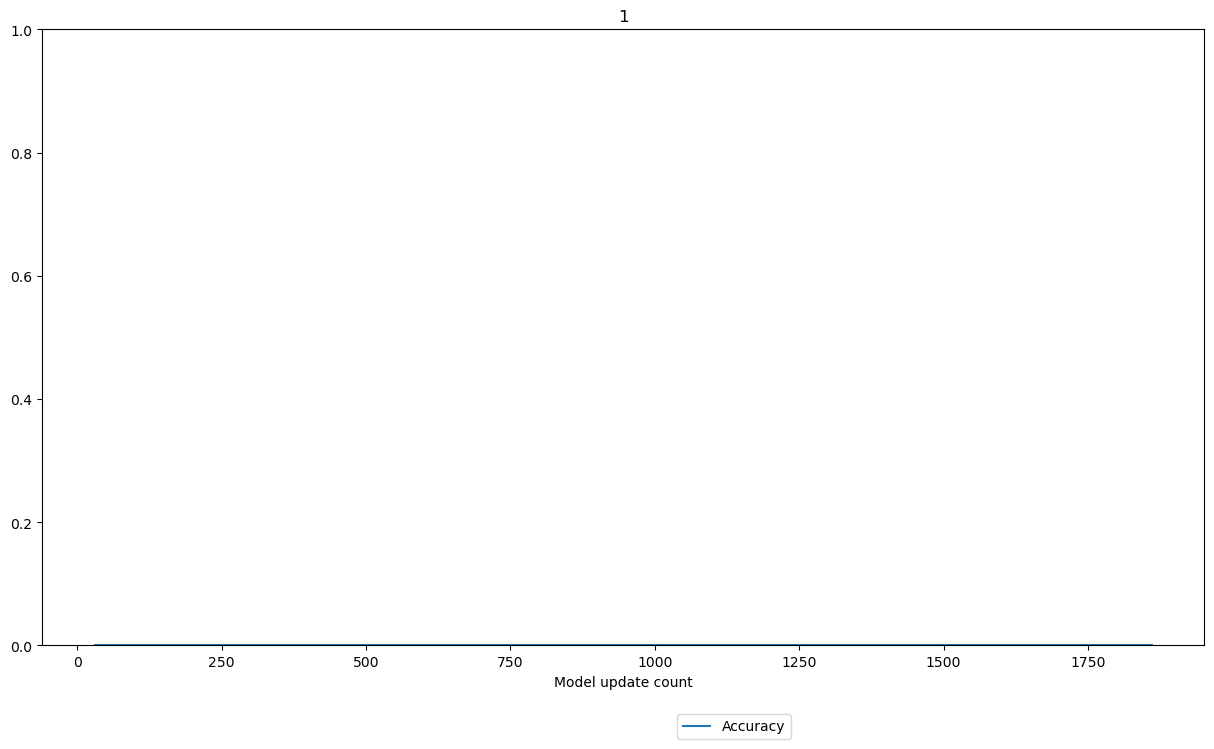

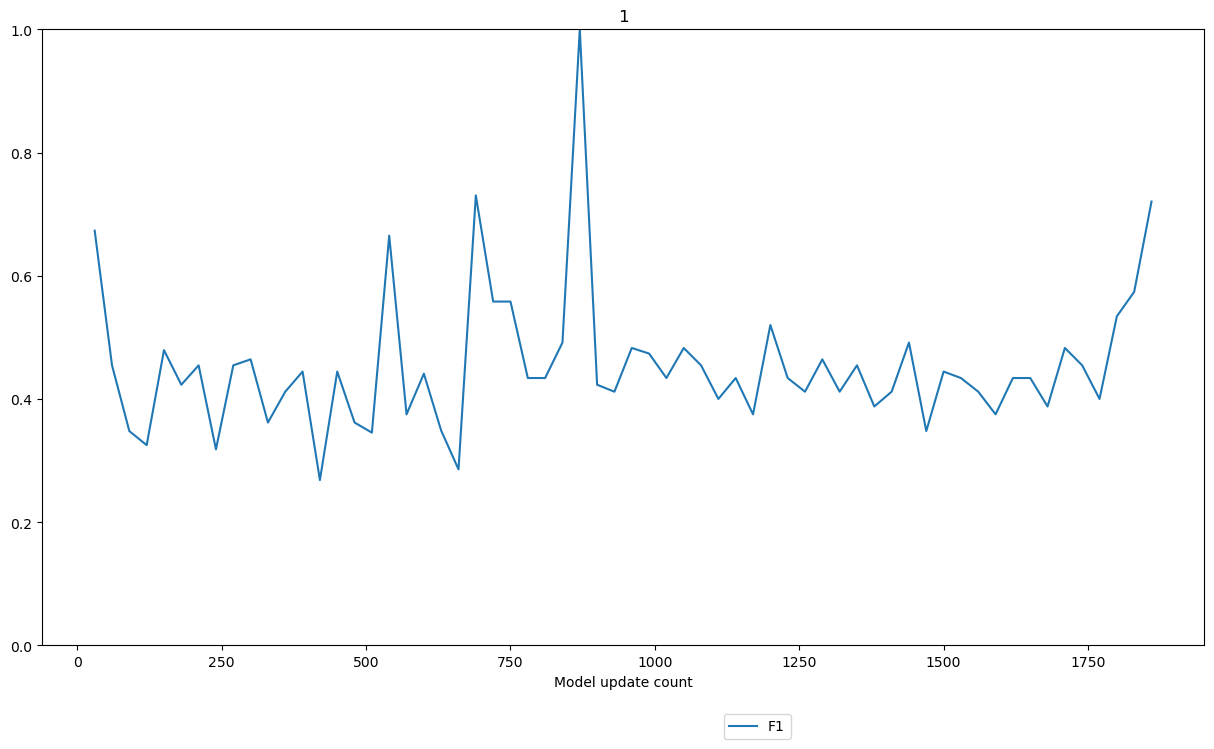

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860]
2
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800,

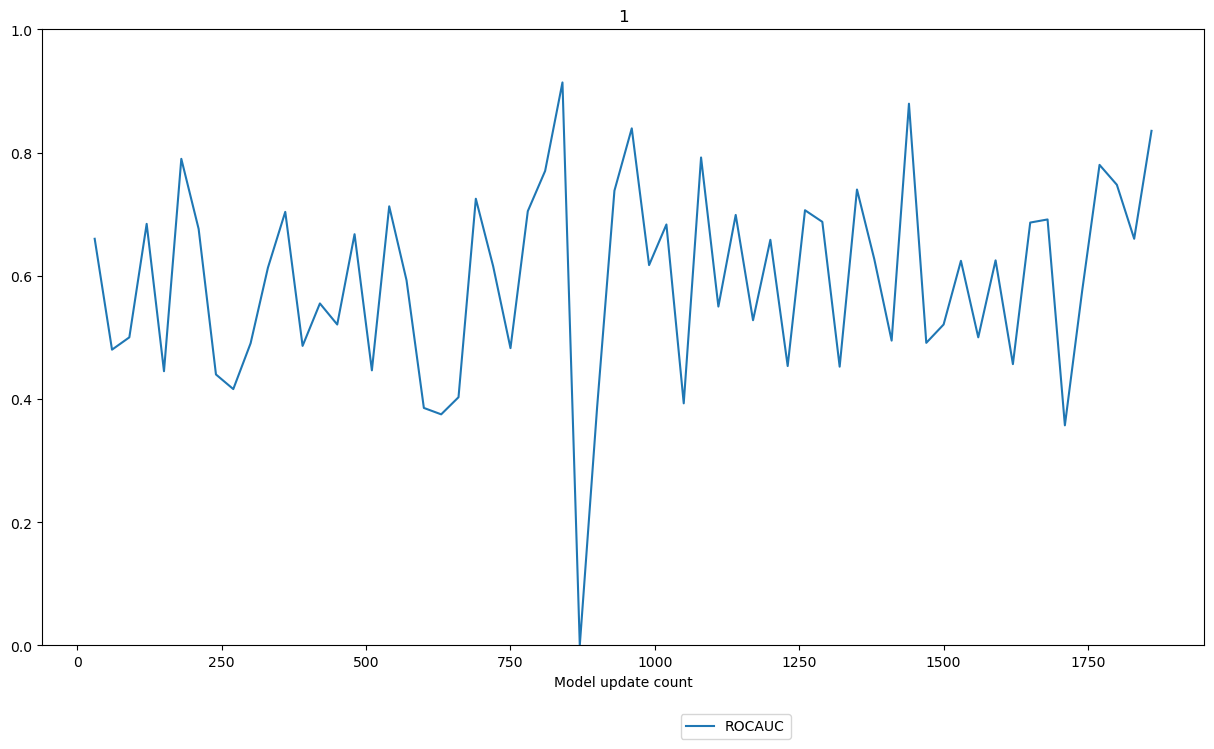

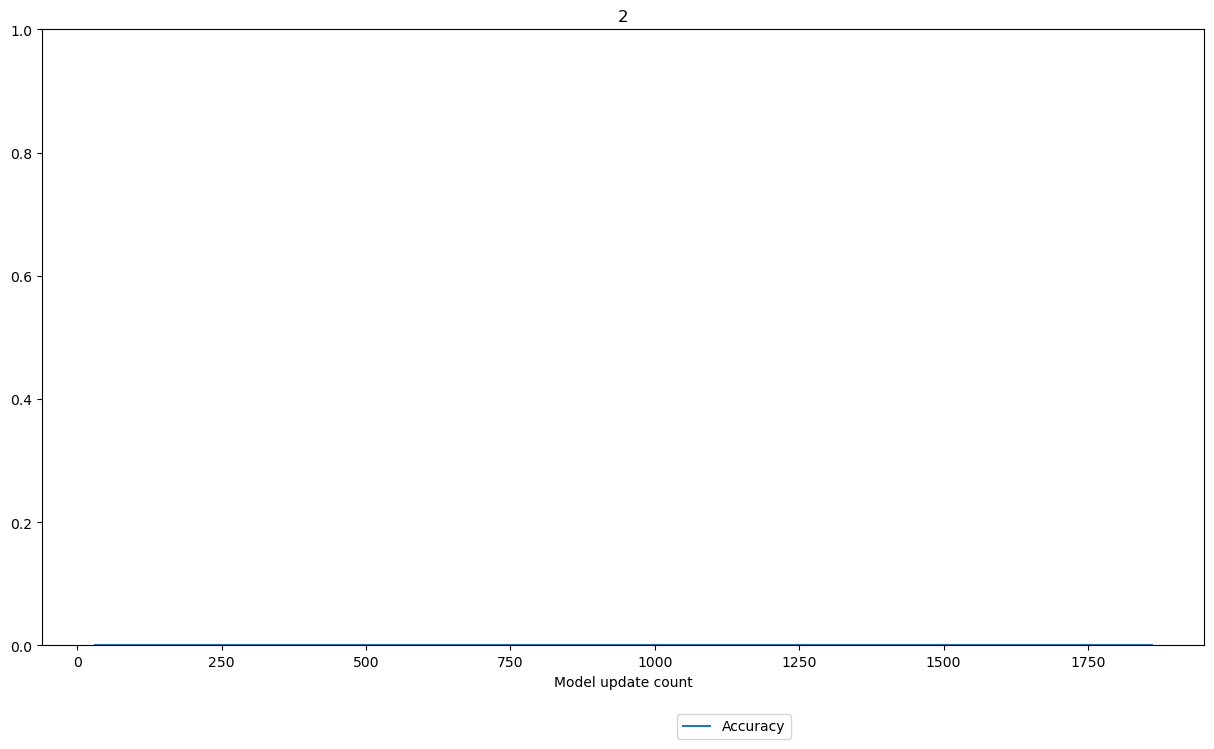

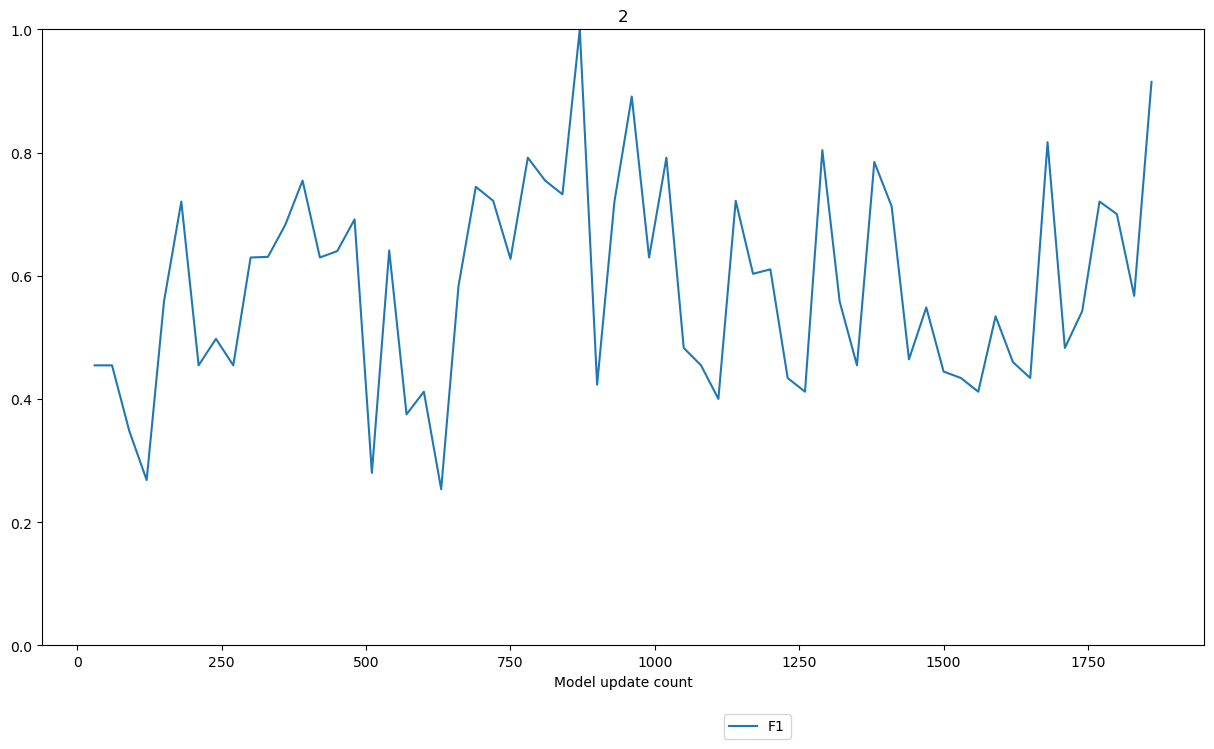

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860]
3
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1351, 1381, 1411, 1441, 1471, 1501, 1531, 1561, 1591, 1621, 1651, 1681, 1711, 1741, 1771, 1801, 1831, 1861]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1351, 1381, 1411, 1441, 1471, 1501, 1531, 1561, 1591, 1621, 1651, 1681, 1711, 1741, 1771, 1801,

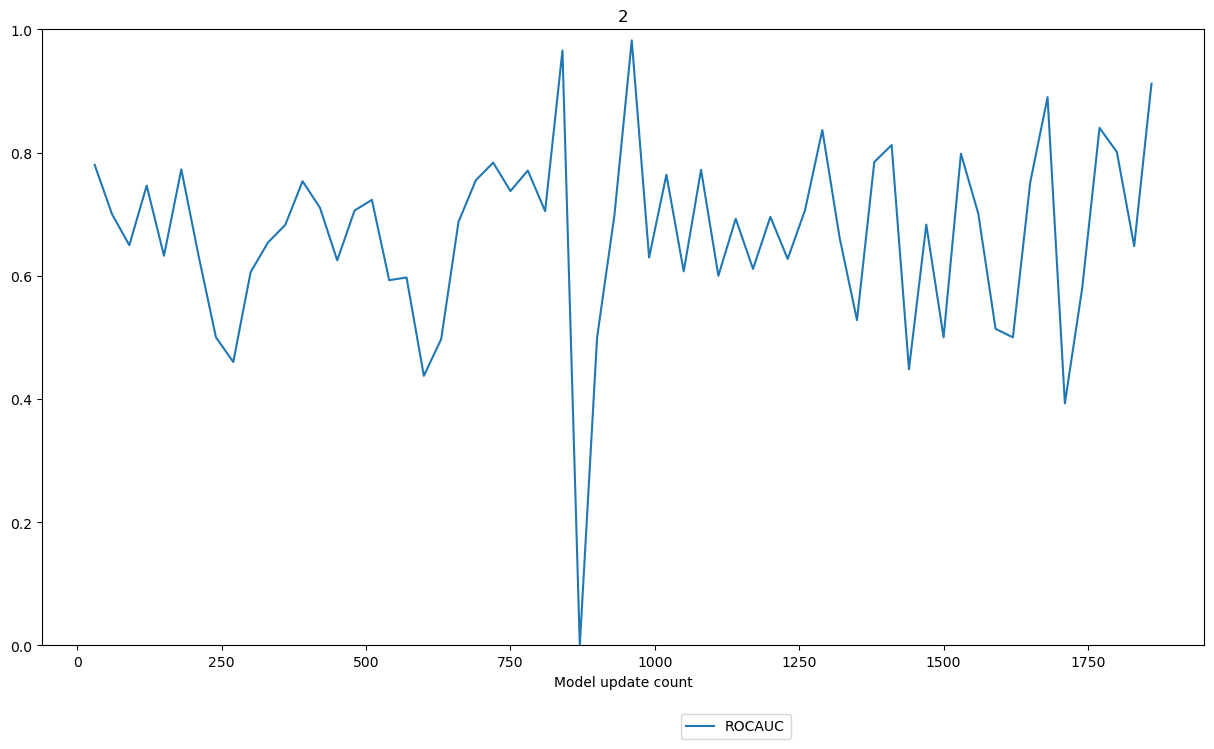

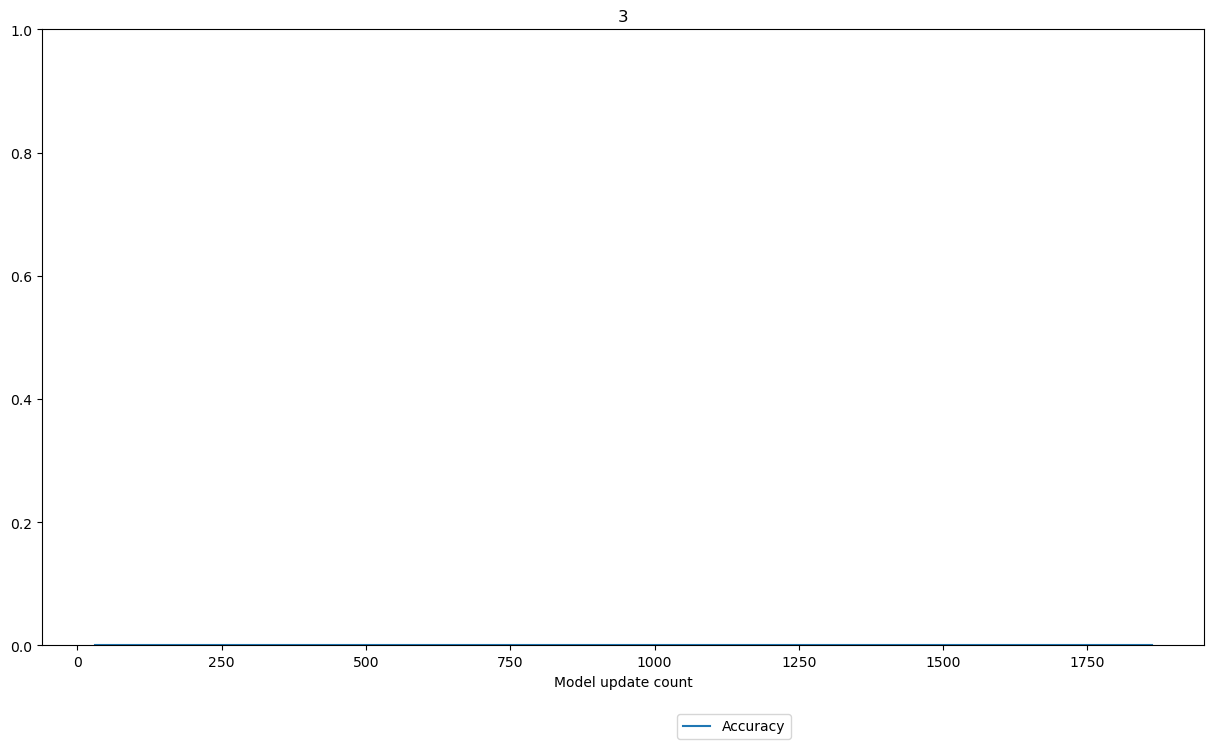

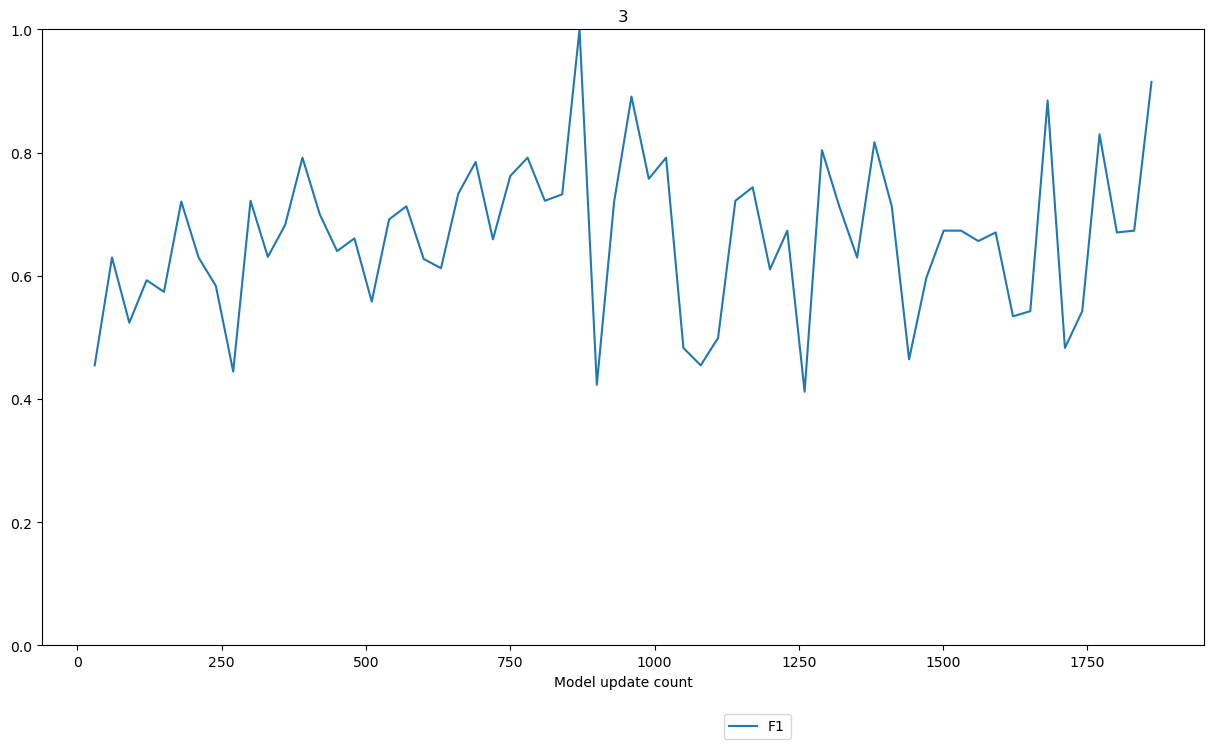

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1351, 1381, 1411, 1441, 1471, 1501, 1531, 1561, 1591, 1621, 1651, 1681, 1711, 1741, 1771, 1801, 1831, 1861]
4
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 811, 841, 871, 901, 931, 961, 991, 1021, 1051, 1081, 1112, 1143, 1173, 1203, 1233, 1263, 1294, 1325, 1356, 1386, 1416, 1446, 1476, 1506, 1536, 1566, 1596, 1626, 1656, 1686, 1716, 1746, 1776, 1806, 1836, 1866]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 811, 841, 871, 901, 931, 961, 991, 1021, 1051, 1081, 1112, 1143, 1173, 1203, 1233, 1263, 1294, 1325, 1356, 1386, 1416, 1446, 1476, 1506, 1536, 1566, 1596, 1626, 1656, 1686, 1716, 1746, 1776, 1806,

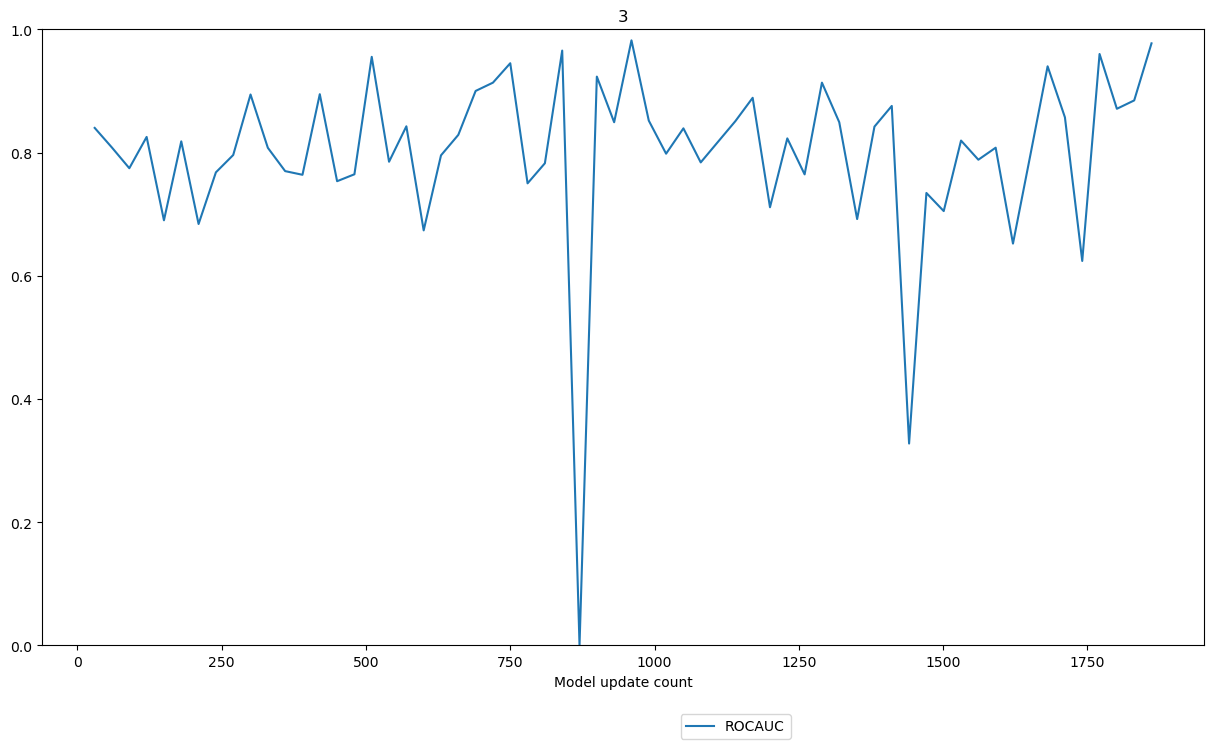

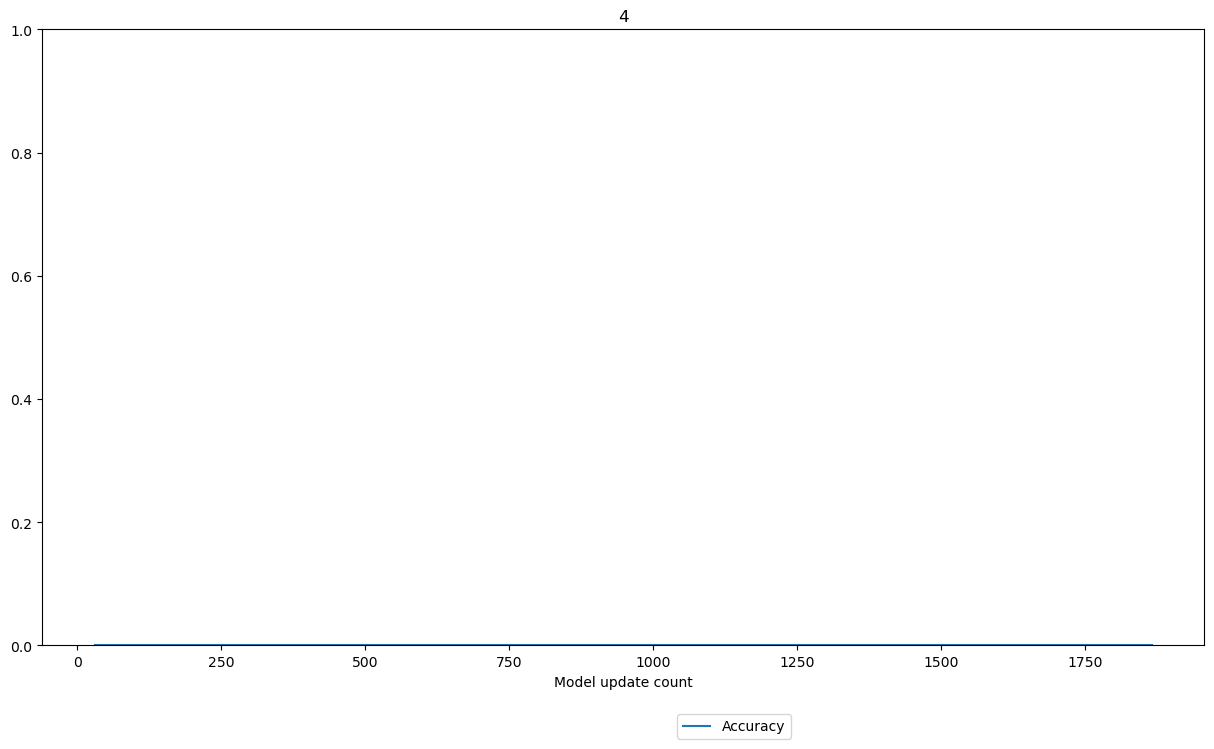

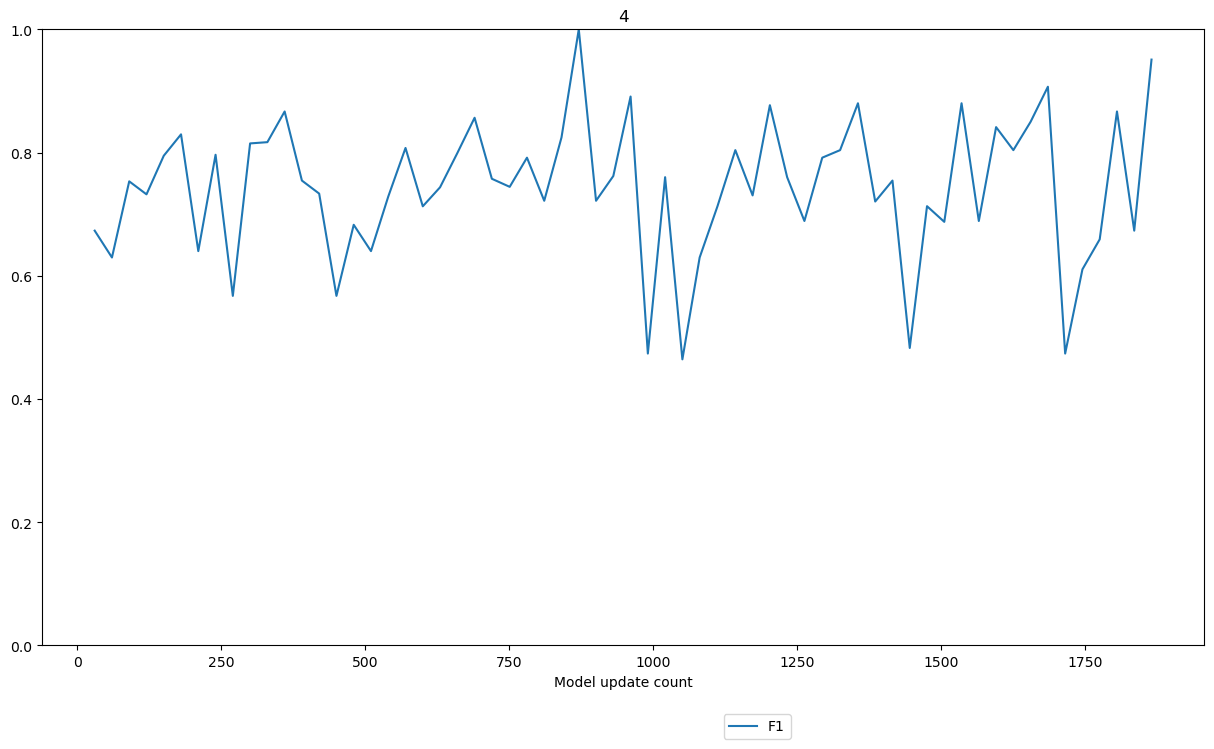

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 811, 841, 871, 901, 931, 961, 991, 1021, 1051, 1081, 1112, 1143, 1173, 1203, 1233, 1263, 1294, 1325, 1356, 1386, 1416, 1446, 1476, 1506, 1536, 1566, 1596, 1626, 1656, 1686, 1716, 1746, 1776, 1806, 1836, 1866]
5
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 812, 842, 872, 902, 932, 962, 992, 1022, 1052, 1082, 1113, 1145, 1175, 1205, 1235, 1266, 1296, 1327, 1358, 1388, 1418, 1448, 1478, 1508, 1538, 1568, 1598, 1628, 1658, 1688, 1718, 1748, 1778, 1808, 1839, 1869]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 812, 842, 872, 902, 932, 962, 992, 1022, 1052, 1082, 1113, 1145, 1175, 1205, 1235, 1266, 1296, 1327, 1358, 1388, 1418, 1448, 1478, 1508, 1538, 1568, 1598, 1628, 1658, 1688, 1718, 1748, 1778, 1808,

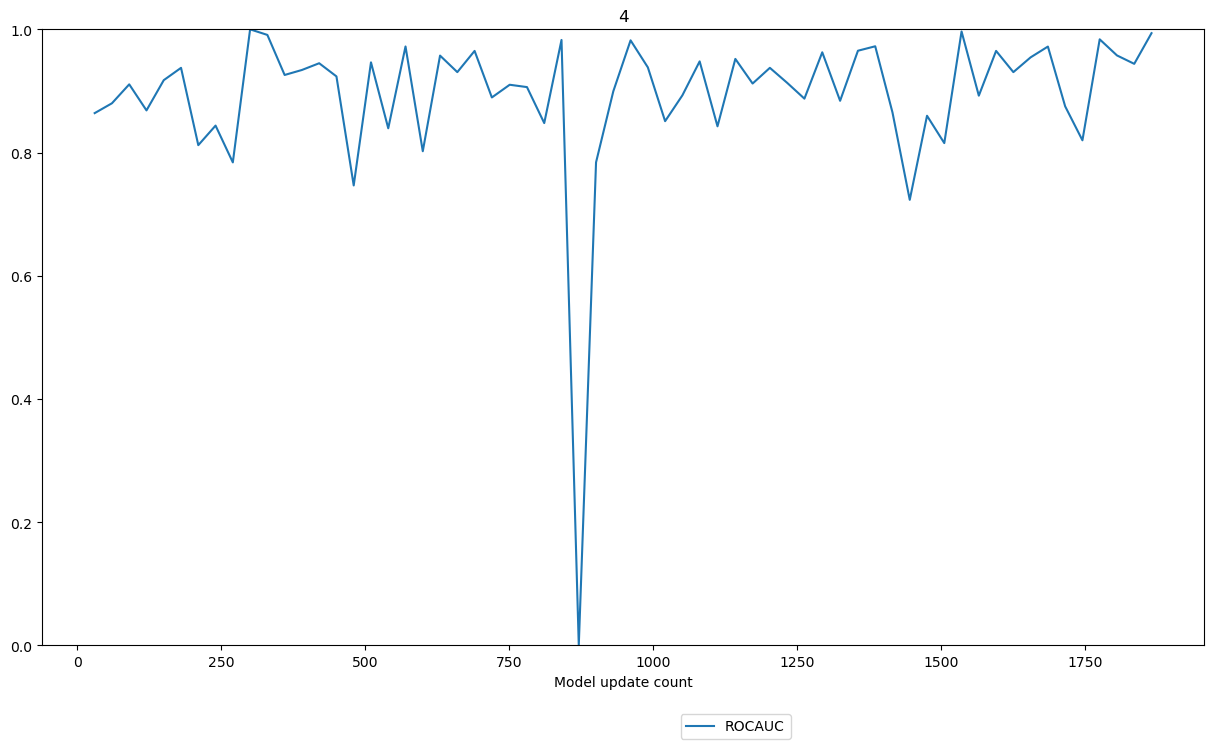

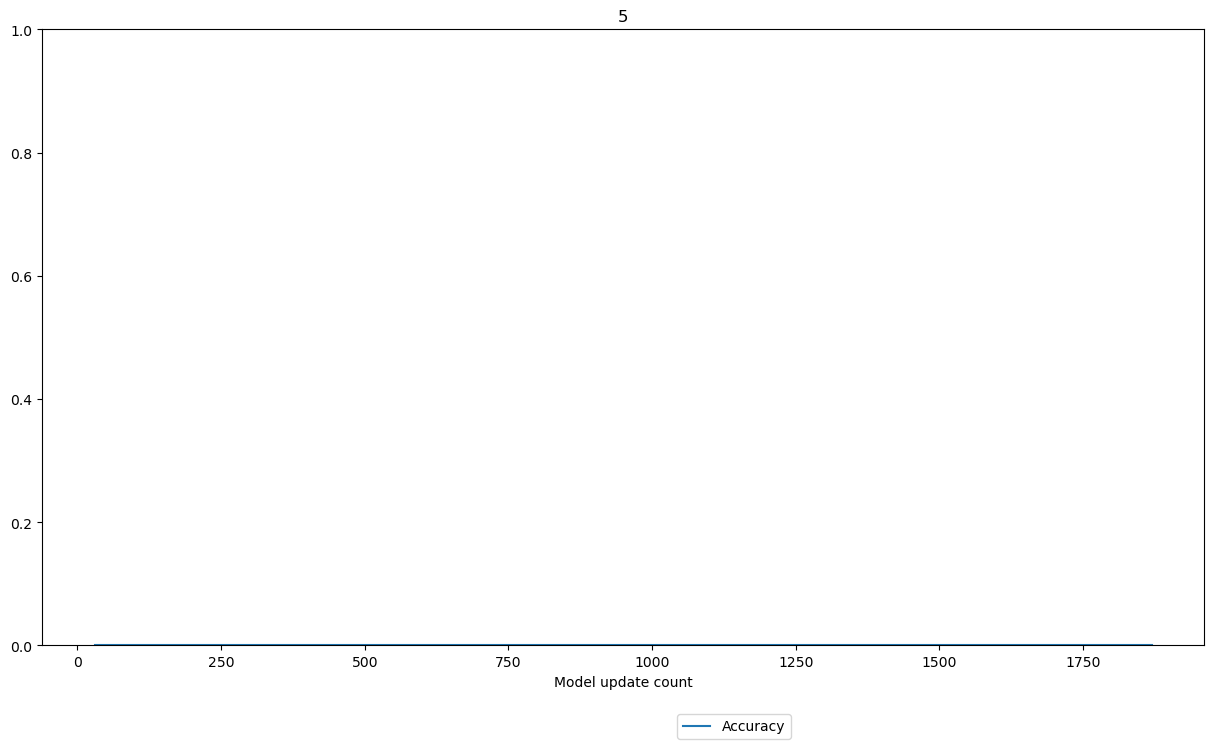

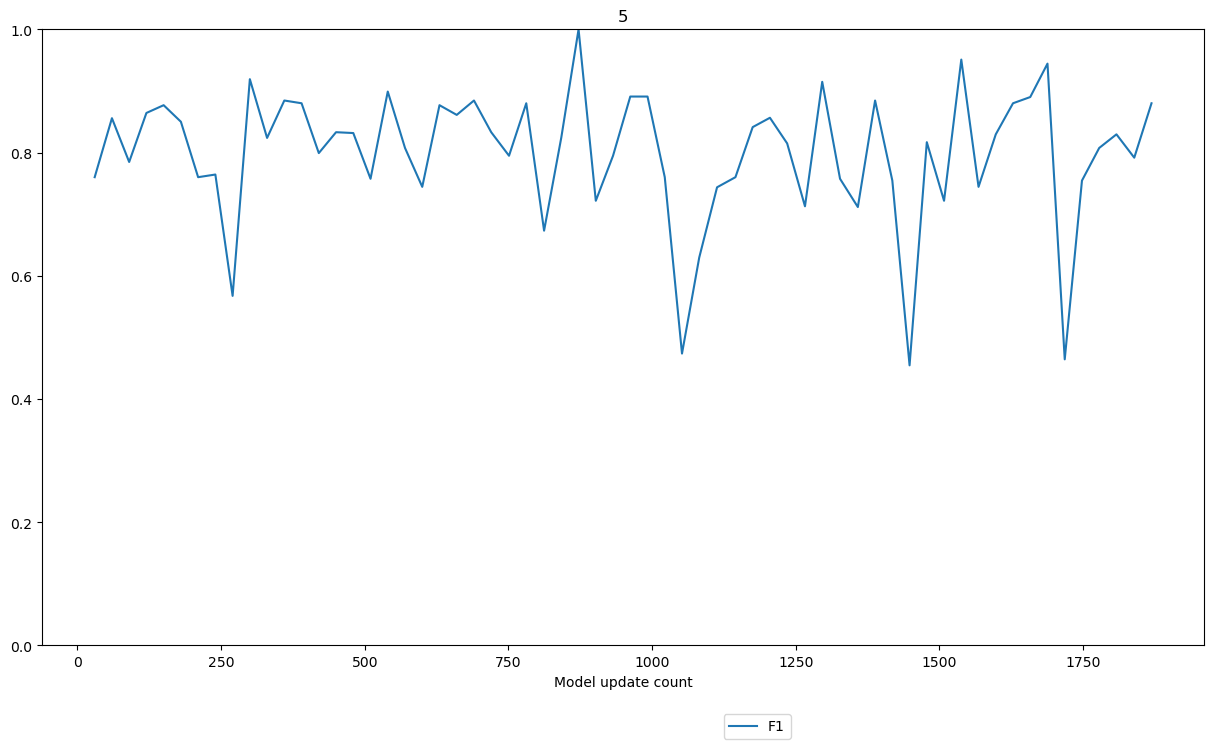

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 812, 842, 872, 902, 932, 962, 992, 1022, 1052, 1082, 1113, 1145, 1175, 1205, 1235, 1266, 1296, 1327, 1358, 1388, 1418, 1448, 1478, 1508, 1538, 1568, 1598, 1628, 1658, 1688, 1718, 1748, 1778, 1808, 1839, 1869]
6
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 812, 842, 872, 902, 932, 963, 993, 1023, 1054, 1084, 1117, 1149, 1179, 1209, 1239, 1270, 1300, 1332, 1362, 1392, 1422, 1452, 1482, 1512, 1542, 1572, 1603, 1633, 1664, 1694, 1725, 1755, 1785, 1815, 1846, 1877]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 812, 842, 872, 902, 932, 963, 993, 1023, 1054, 1084, 1117, 1149, 1179, 1209, 1239, 1270, 1300, 1332, 1362, 1392, 1422, 1452, 1482, 1512, 1542, 1572, 1603, 1633, 1664, 1694, 1725, 1755, 1785, 1815,

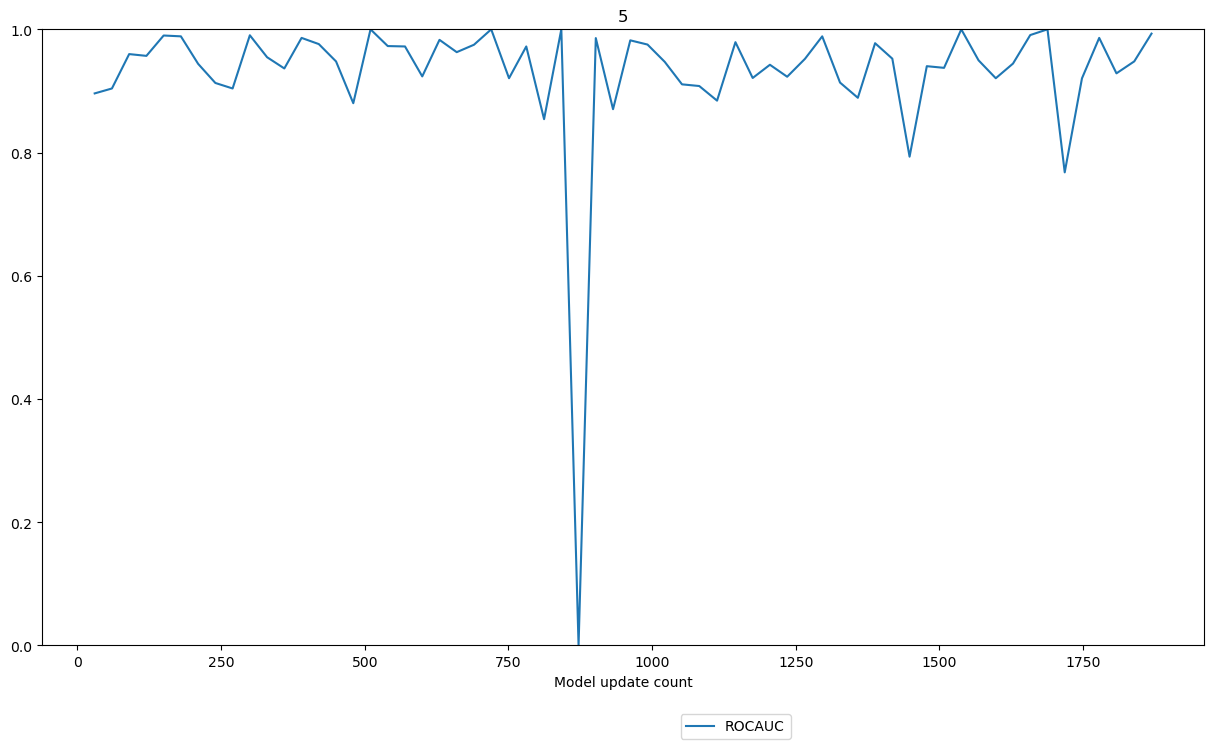

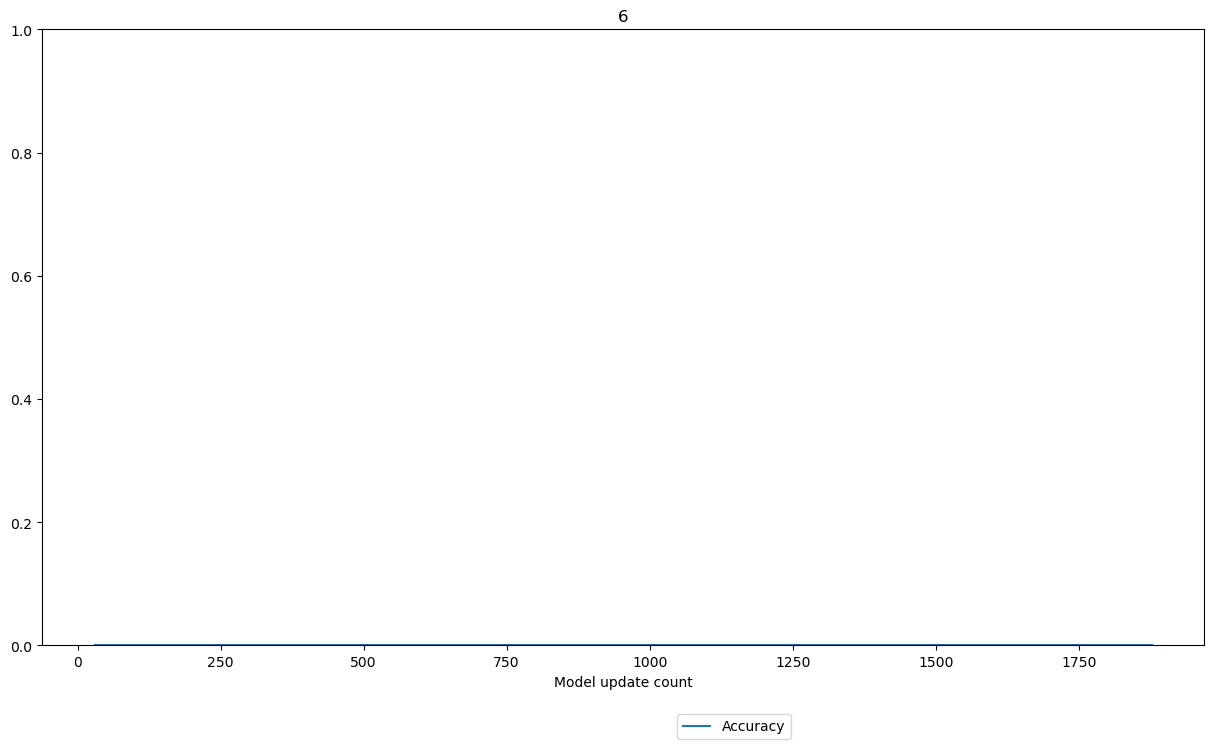

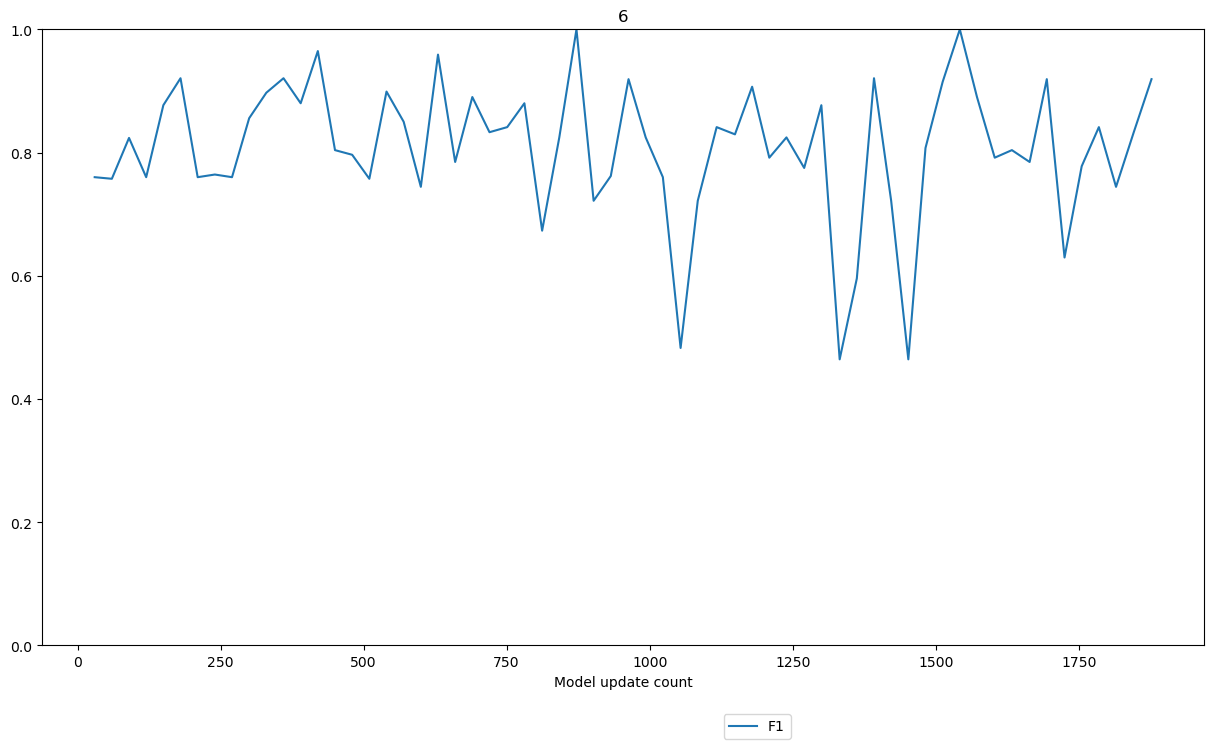

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 751, 781, 812, 842, 872, 902, 932, 963, 993, 1023, 1054, 1084, 1117, 1149, 1179, 1209, 1239, 1270, 1300, 1332, 1362, 1392, 1422, 1452, 1482, 1512, 1542, 1572, 1603, 1633, 1664, 1694, 1725, 1755, 1785, 1815, 1846, 1877]
7
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 752, 782, 813, 843, 873, 904, 934, 965, 995, 1025, 1056, 1088, 1121, 1152, 1182, 1212, 1242, 1274, 1304, 1336, 1366, 1396, 1426, 1456, 1487, 1517, 1547, 1577, 1608, 1638, 1669, 1699, 1731, 1762, 1792, 1823, 1854]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 752, 782, 813, 843, 873, 904, 934, 965, 995, 1025, 1056, 1088, 1121, 1152, 1182, 1212, 1242, 1274, 1304, 1336, 1366, 1396, 1426, 1456, 1487, 1517, 1547, 1577, 1608, 1638, 1669, 1699, 1731, 1762, 1792, 1823, 1854]

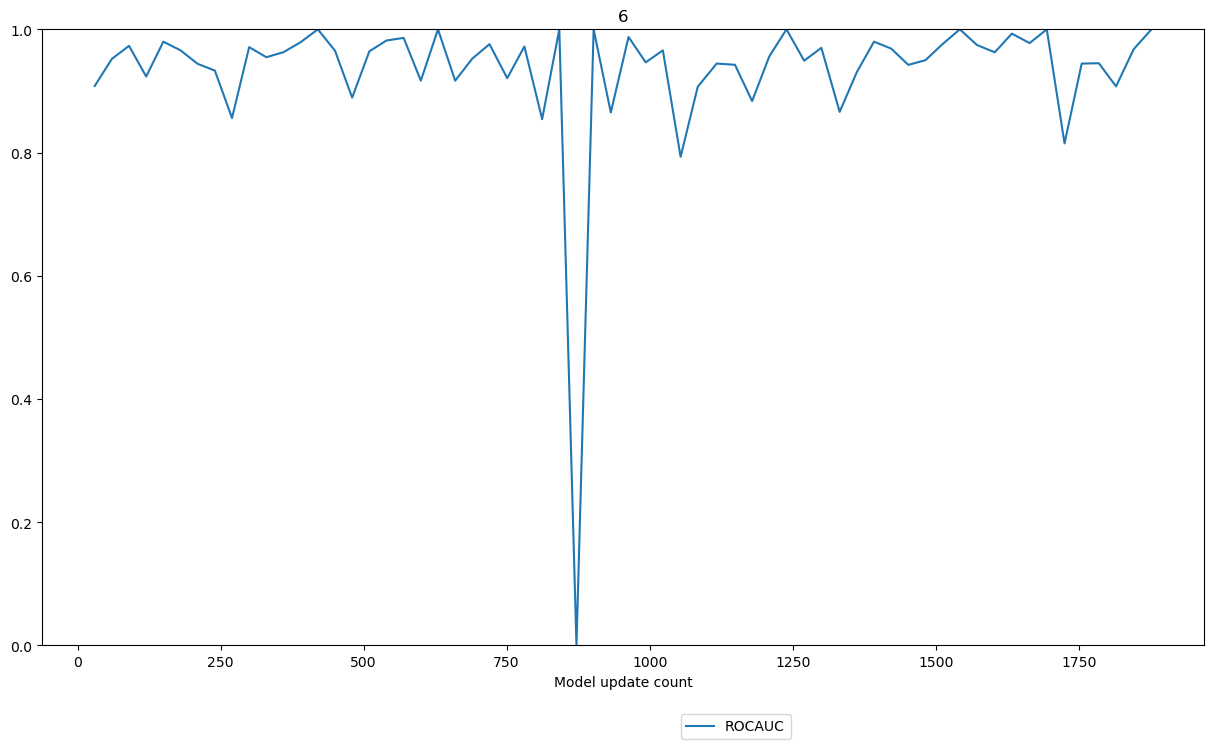

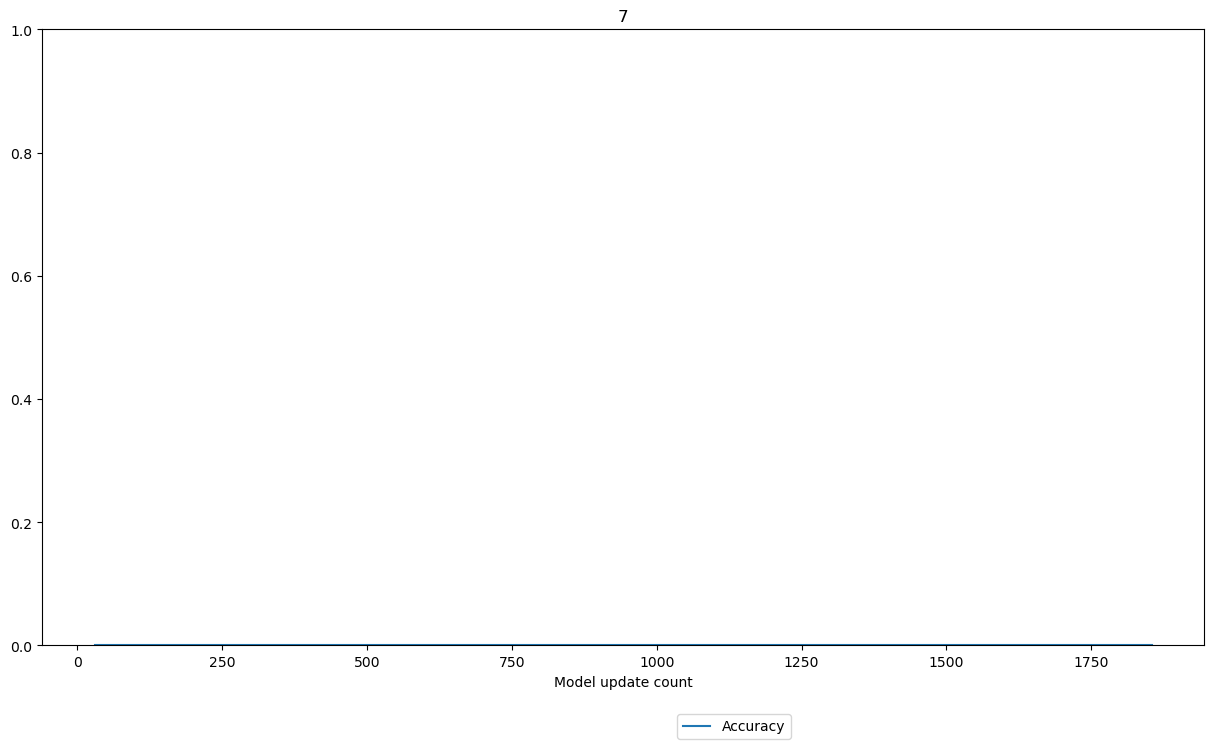

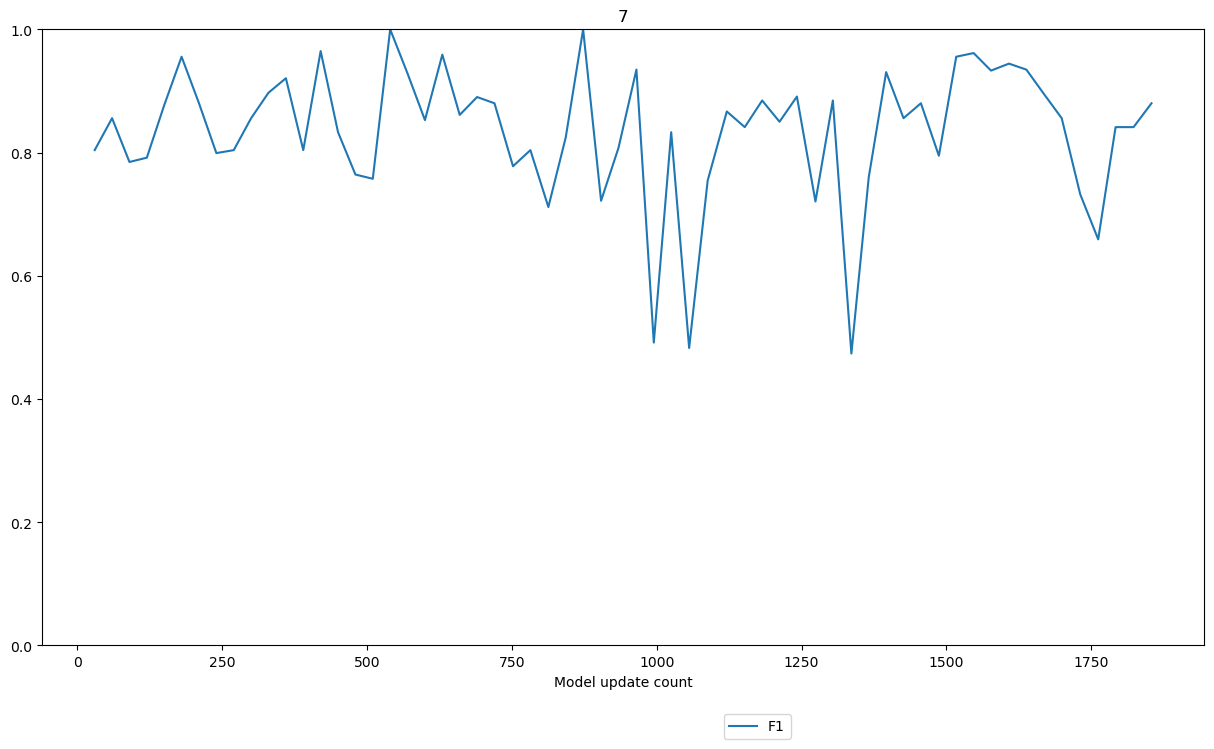

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 752, 782, 813, 843, 873, 904, 934, 965, 995, 1025, 1056, 1088, 1121, 1152, 1182, 1212, 1242, 1274, 1304, 1336, 1366, 1396, 1426, 1456, 1487, 1517, 1547, 1577, 1608, 1638, 1669, 1699, 1731, 1762, 1792, 1823, 1854]
8
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 752, 782, 814, 844, 874, 906, 936, 967, 997, 1027, 1058, 1091, 1123, 1154, 1184, 1214, 1245, 1278, 1311, 1342, 1372, 1403, 1433, 1463, 1496, 1526, 1556, 1586, 1618, 1649, 1679, 1710, 1741, 1773, 1803, 1834, 1867]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 752, 782, 814, 844, 874, 906, 936, 967, 997, 1027, 1058, 1091, 1123, 1154, 1184, 1214, 1245, 1278, 1311, 1342, 1372, 1403, 1433, 1463, 1496, 1526, 1556, 1586, 1618, 1649, 1679, 1710, 1741, 1773, 1803, 1834, 1867]


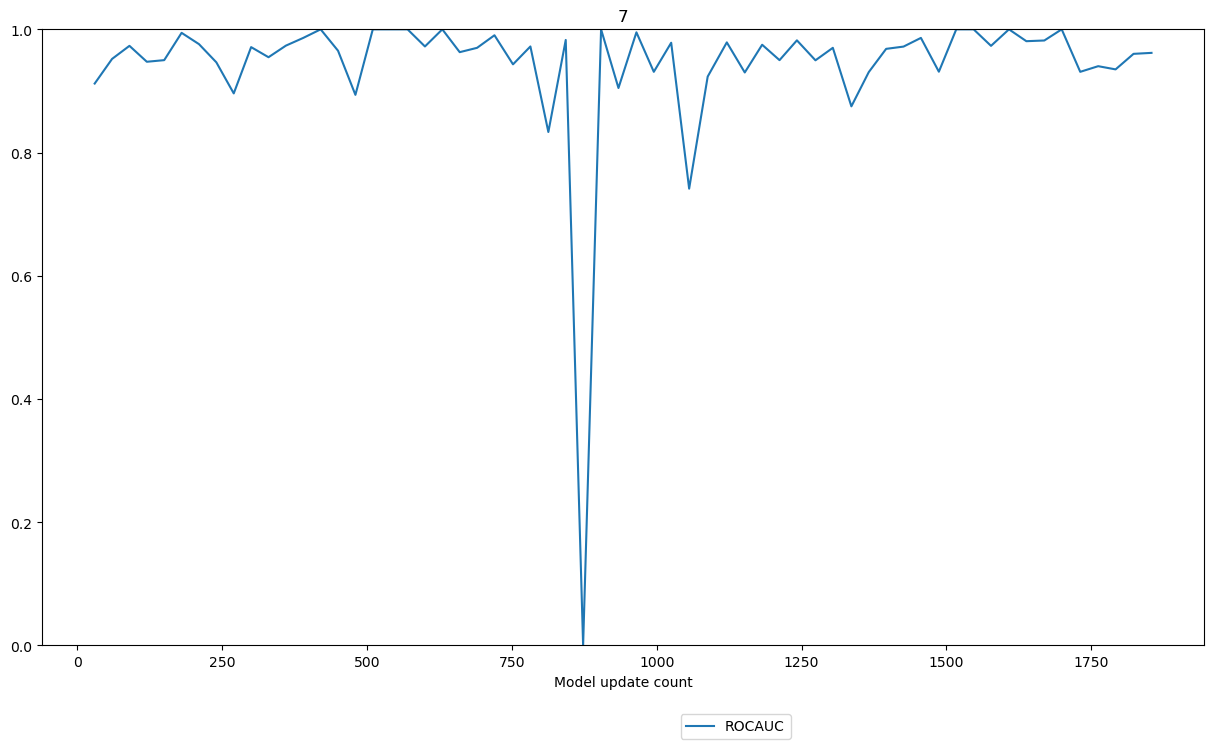

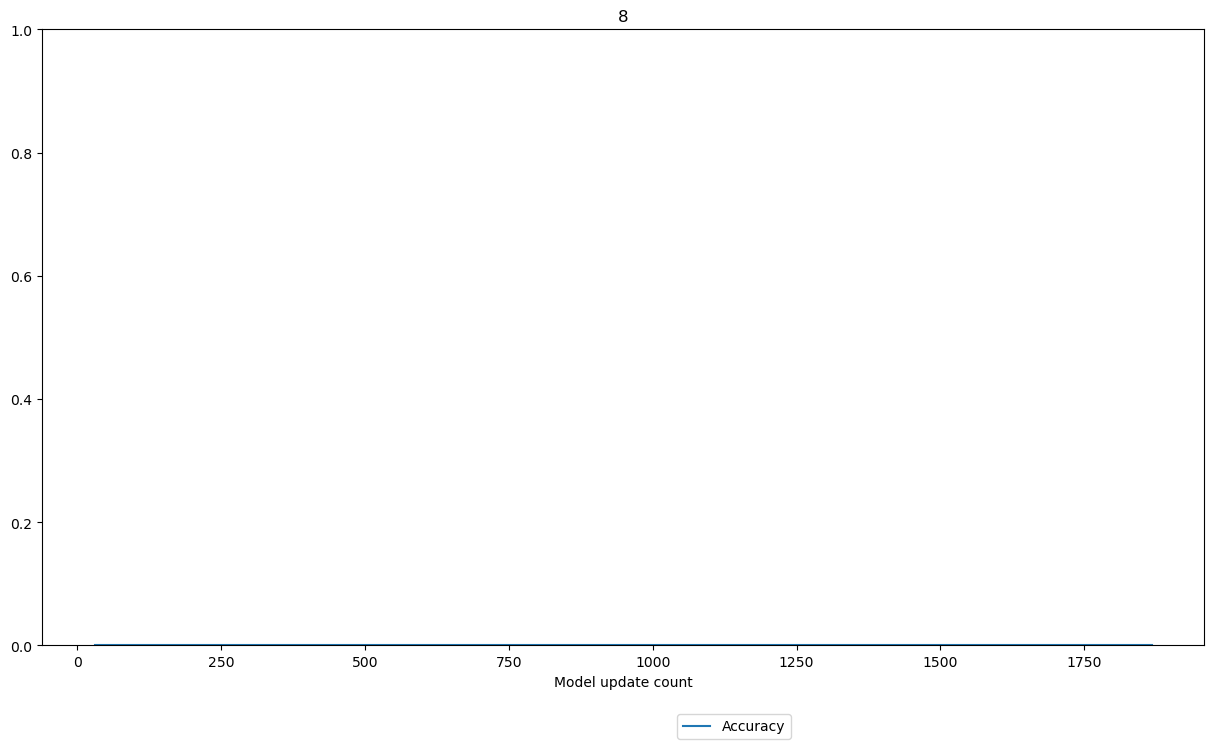

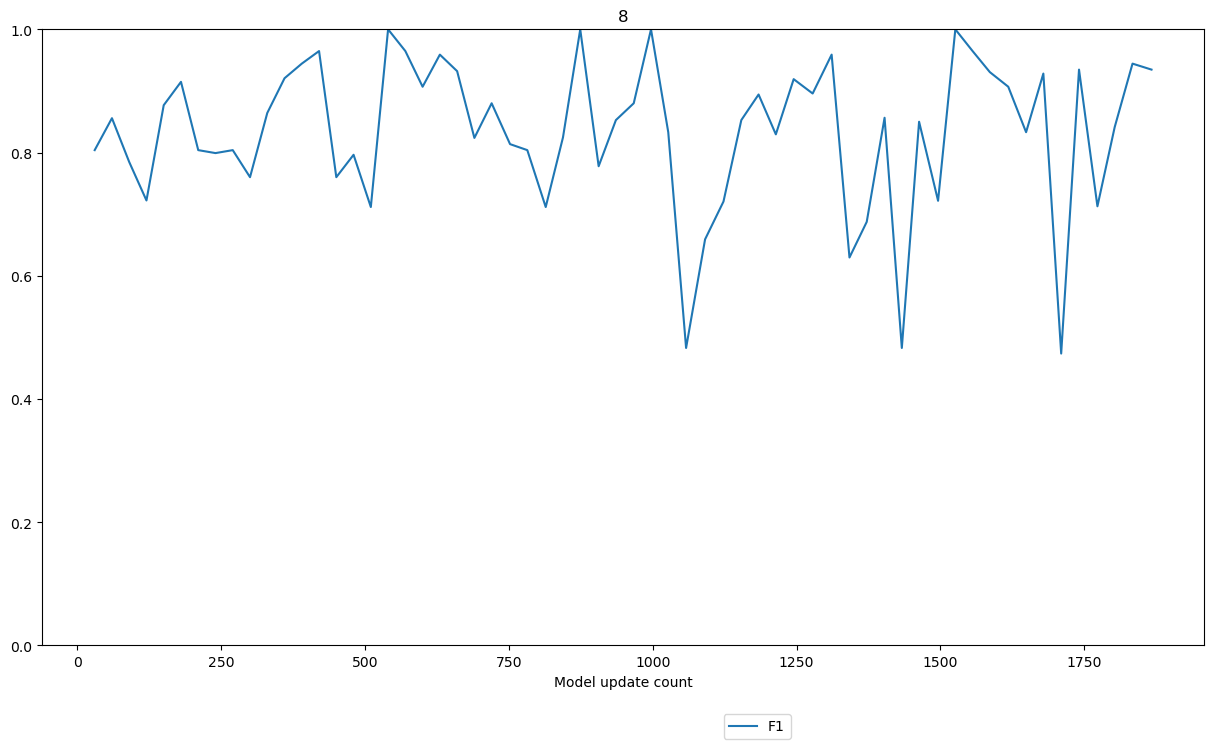

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 752, 782, 814, 844, 874, 906, 936, 967, 997, 1027, 1058, 1091, 1123, 1154, 1184, 1214, 1245, 1278, 1311, 1342, 1372, 1403, 1433, 1463, 1496, 1526, 1556, 1586, 1618, 1649, 1679, 1710, 1741, 1773, 1803, 1834, 1867]
9
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 662, 692, 722, 754, 784, 816, 846, 876, 908, 938, 969, 999, 1029, 1060, 1095, 1126, 1157, 1187, 1218, 1250, 1284, 1317, 1350, 1382, 1413, 1443, 1474, 1508, 1541, 1571, 1605, 1635, 1668, 1698, 1731, 1764, 1794, 1825, 1859]
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 662, 692, 722, 754, 784, 816, 846, 876, 908, 938, 969, 999, 1029, 1060, 1095, 1126, 1157, 1187, 1218, 1250, 1284, 1317, 1350, 1382, 1413, 1443, 1474, 1508, 1541, 1571, 1605, 1635, 1668, 1698, 1731, 1764, 1794, 1825, 1859]


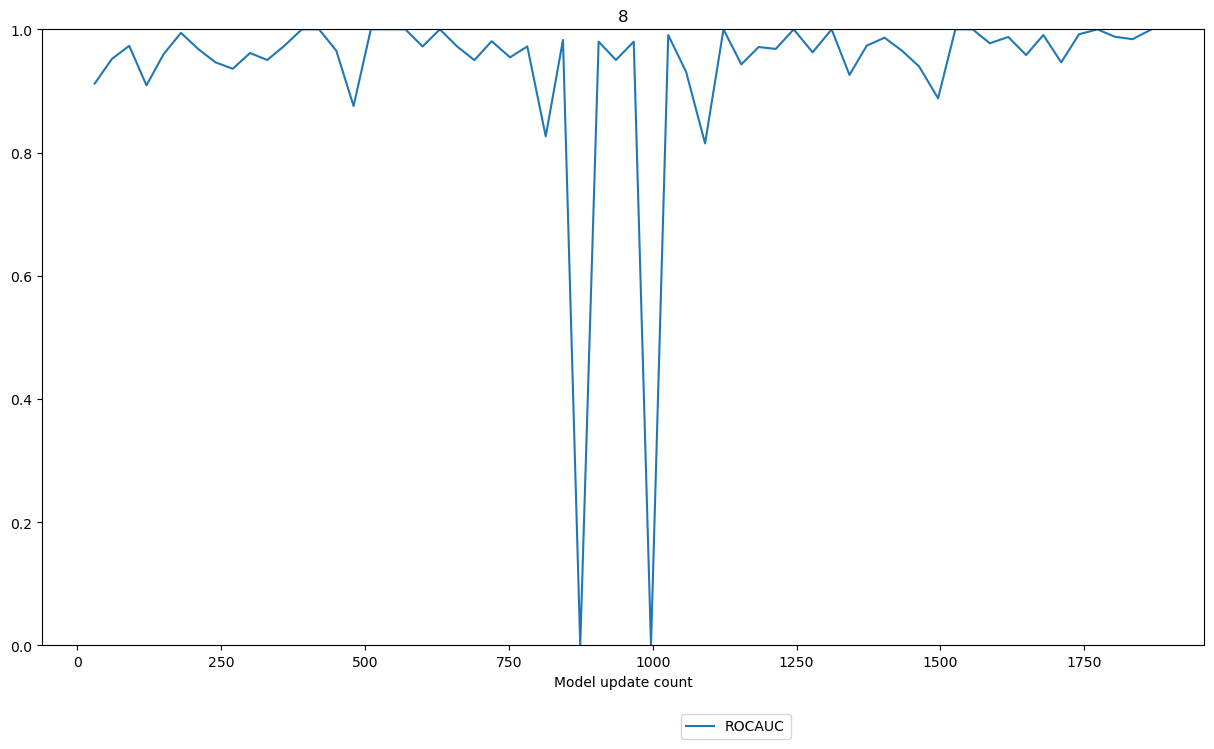

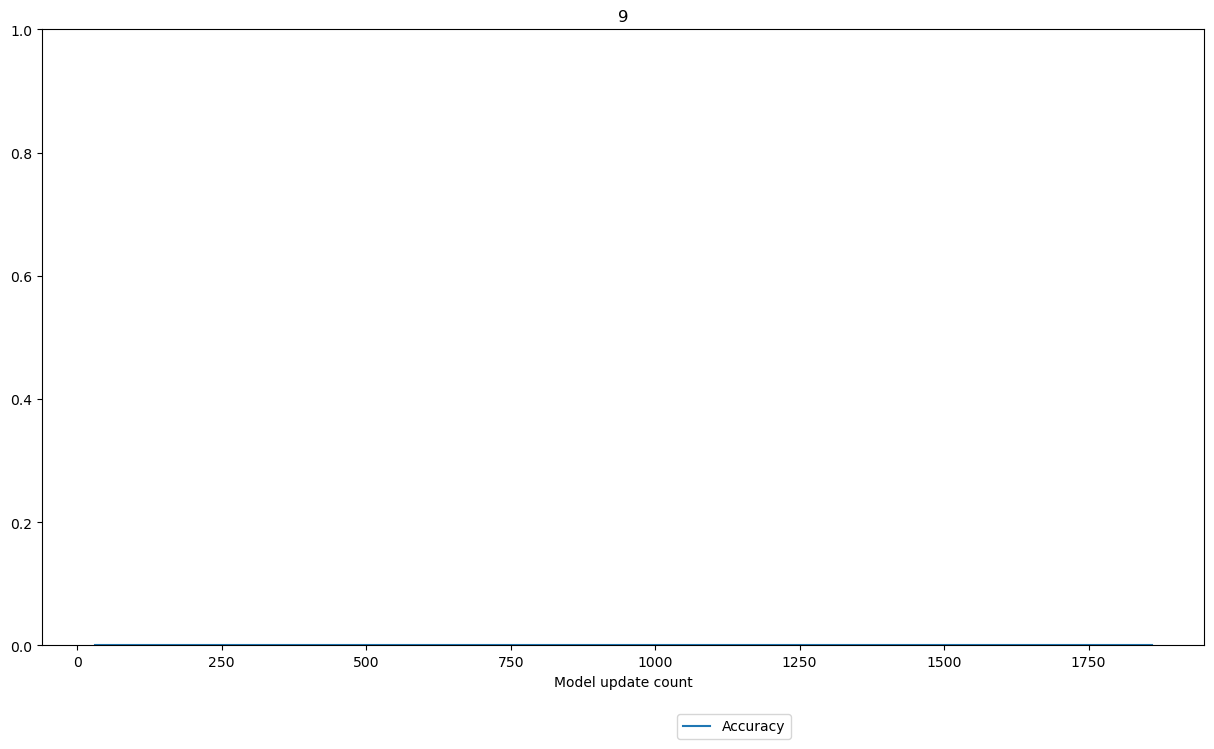

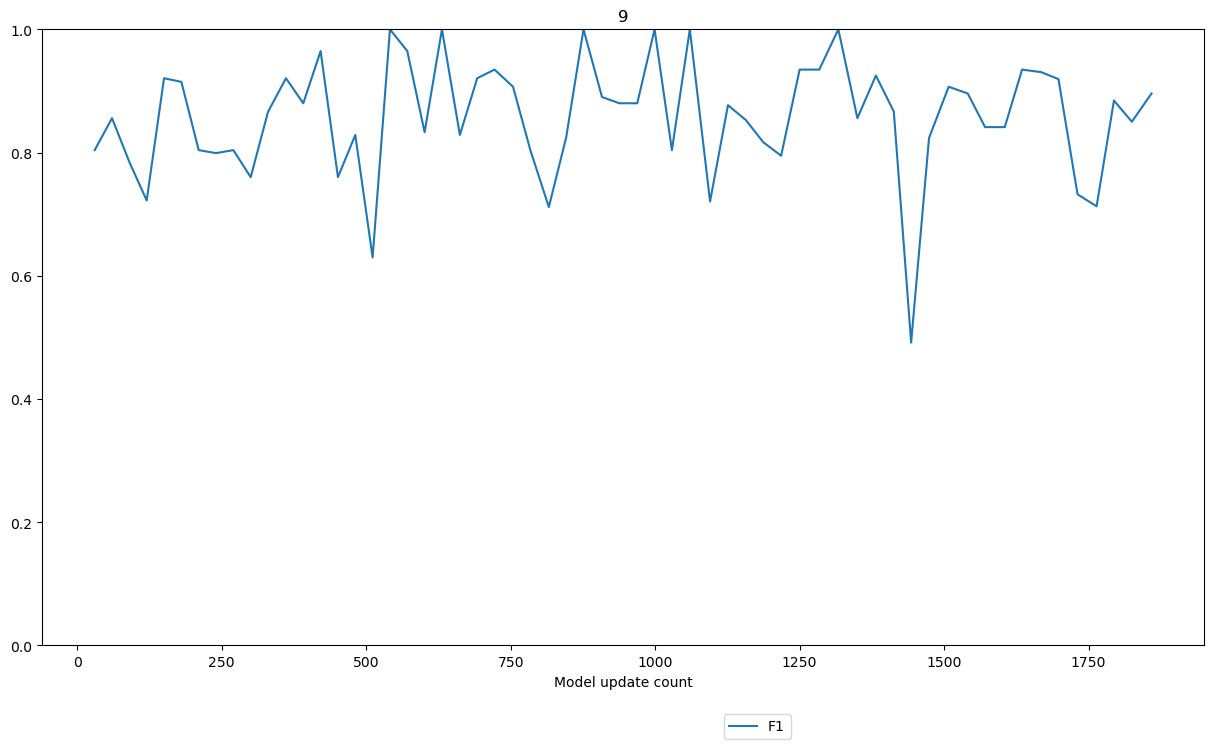

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 662, 692, 722, 754, 784, 816, 846, 876, 908, 938, 969, 999, 1029, 1060, 1095, 1126, 1157, 1187, 1218, 1250, 1284, 1317, 1350, 1382, 1413, 1443, 1474, 1508, 1541, 1571, 1605, 1635, 1668, 1698, 1731, 1764, 1794, 1825, 1859]
10
[30, 60, 90, 122, 152, 182, 212, 242, 272, 303, 333, 364, 394, 424, 454, 485, 515, 545, 575, 606, 637, 667, 697, 727, 759, 789, 822, 853, 883, 916, 946, 977, 1007, 1038, 1068, 1103, 1135, 1166, 1196, 1227, 1263, 1296, 1332, 1365, 1396, 1429, 1459, 1493, 1525, 1559, 1591, 1624, 1657, 1688, 1722, 1760, 1797, 1828, 1864]
[30, 60, 90, 122, 152, 182, 212, 242, 272, 303, 333, 364, 394, 424, 454, 485, 515, 545, 575, 606, 637, 667, 697, 727, 759, 789, 822, 853, 883, 916, 946, 977, 1007, 1038, 1068, 1103, 1135, 1166, 1196, 1227, 1263, 1296, 1332, 1365, 1396, 1429, 1459, 1493, 1525, 1559, 1591, 1624, 1657, 1688, 1722, 1760, 1797, 1828, 1864]


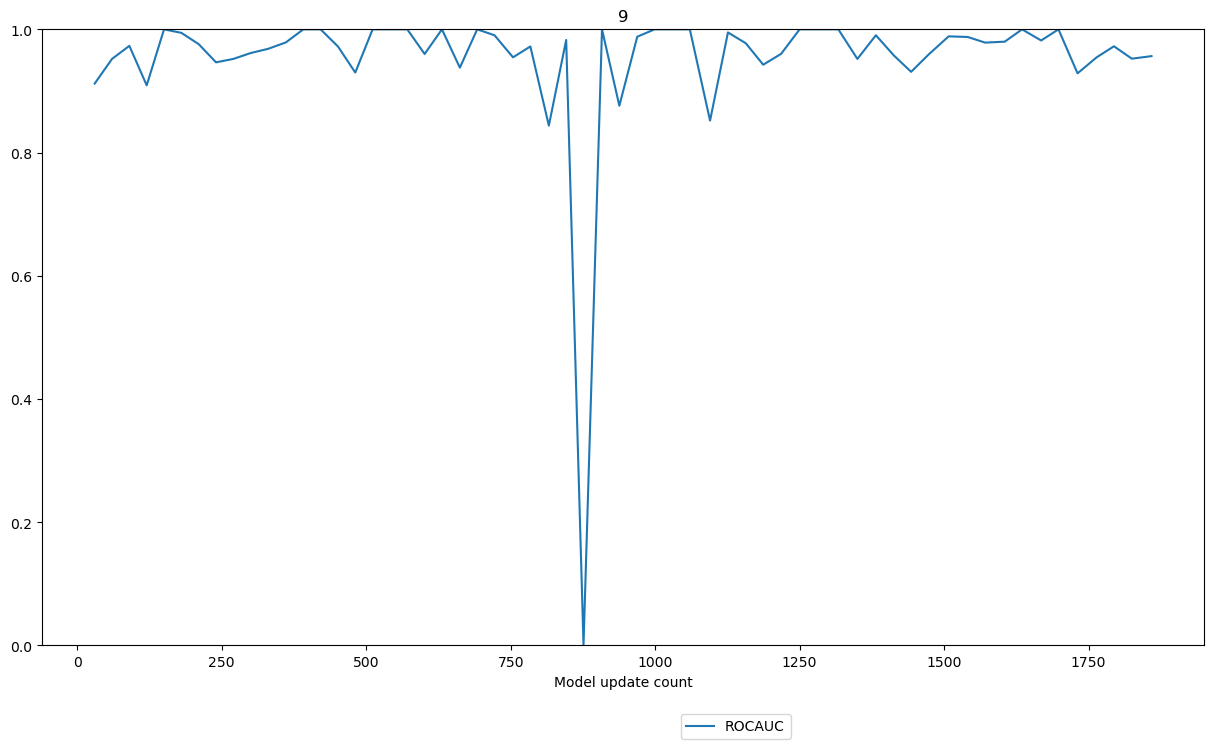

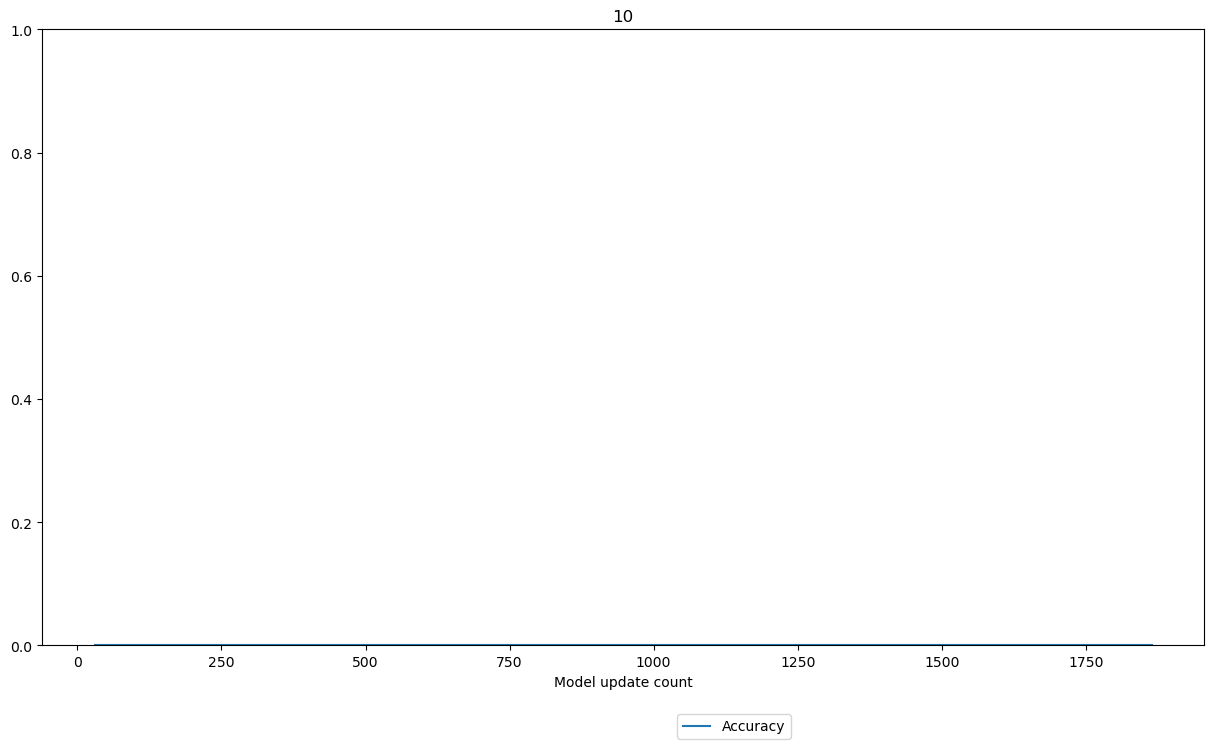

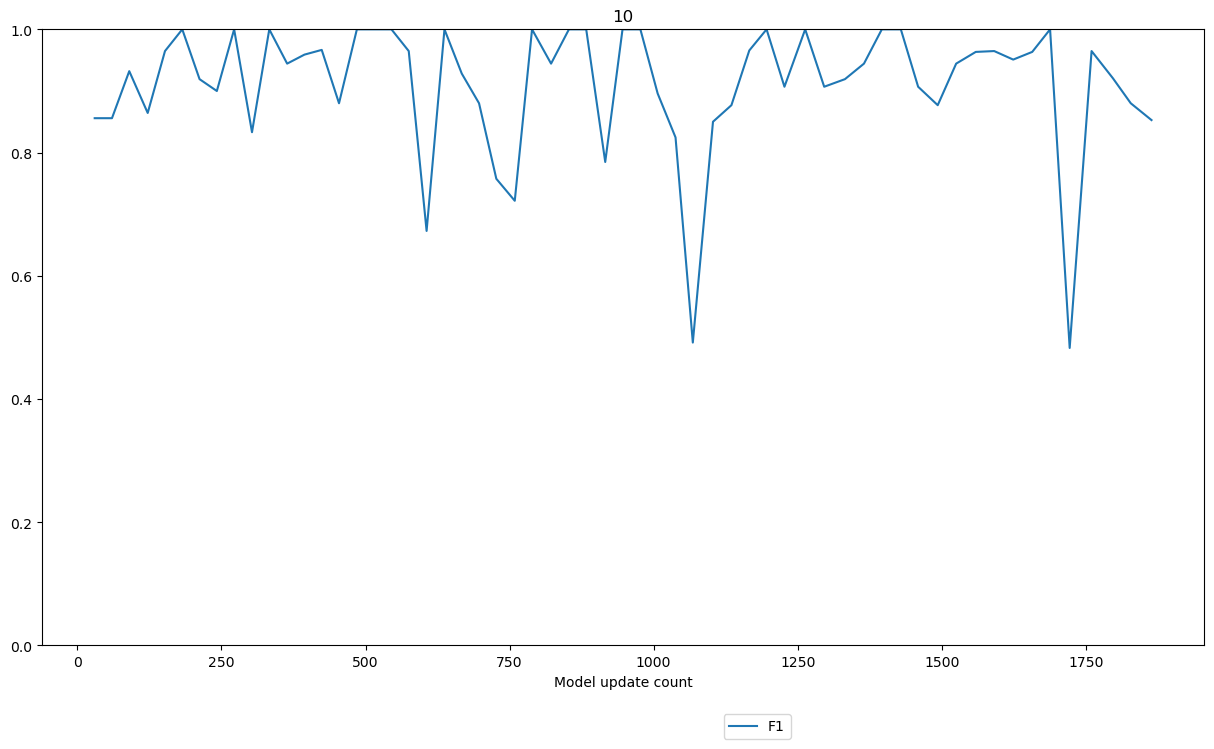

[30, 60, 90, 122, 152, 182, 212, 242, 272, 303, 333, 364, 394, 424, 454, 485, 515, 545, 575, 606, 637, 667, 697, 727, 759, 789, 822, 853, 883, 916, 946, 977, 1007, 1038, 1068, 1103, 1135, 1166, 1196, 1227, 1263, 1296, 1332, 1365, 1396, 1429, 1459, 1493, 1525, 1559, 1591, 1624, 1657, 1688, 1722, 1760, 1797, 1828, 1864]
11
[30, 60, 90, 122, 152, 182, 213, 243, 273, 304, 334, 365, 396, 426, 456, 487, 517, 547, 577, 608, 640, 670, 700, 734, 764, 795, 831, 863, 894, 928, 958, 989, 1022, 1053, 1085, 1121, 1153, 1185, 1218, 1254, 1288, 1326, 1366, 1401, 1435, 1467, 1501, 1536, 1572, 1608, 1638, 1674, 1711, 1751, 1792, 1830, 1867]
[30, 60, 90, 122, 152, 182, 213, 243, 273, 304, 334, 365, 396, 426, 456, 487, 517, 547, 577, 608, 640, 670, 700, 734, 764, 795, 831, 863, 894, 928, 958, 989, 1022, 1053, 1085, 1121, 1153, 1185, 1218, 1254, 1288, 1326, 1366, 1401, 1435, 1467, 1501, 1536, 1572, 1608, 1638, 1674, 1711, 1751, 1792, 1830, 1867]


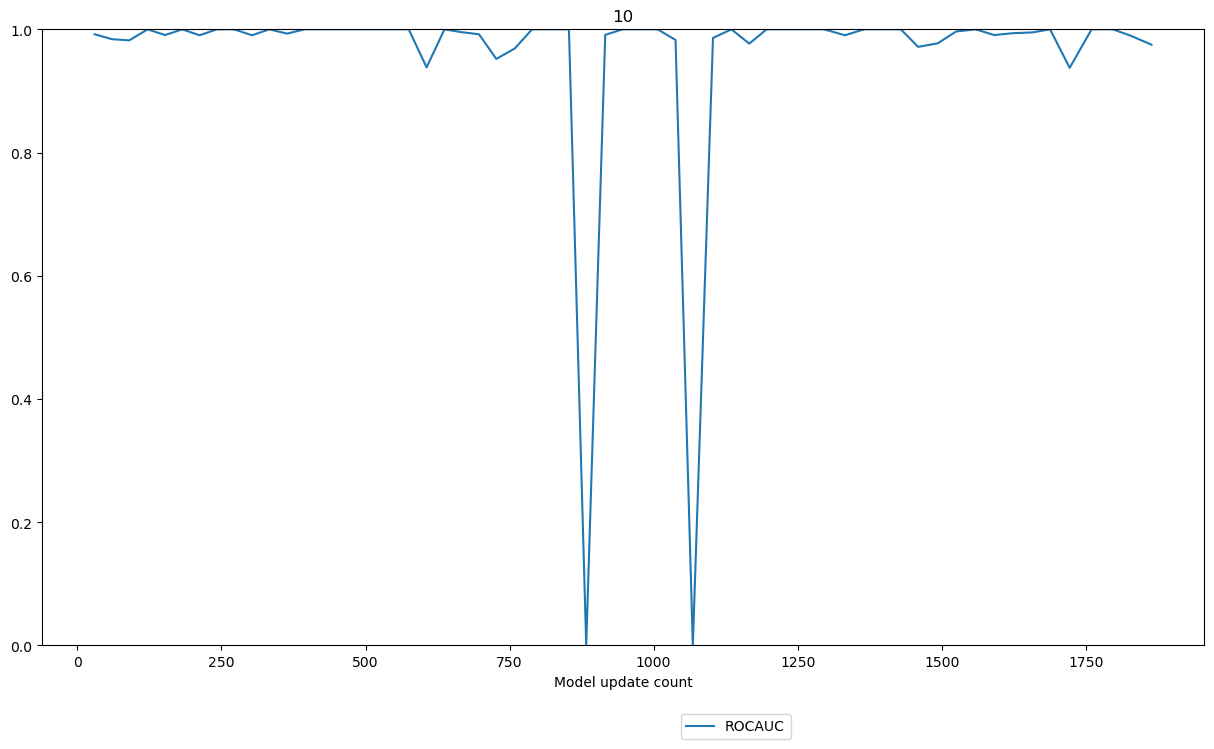

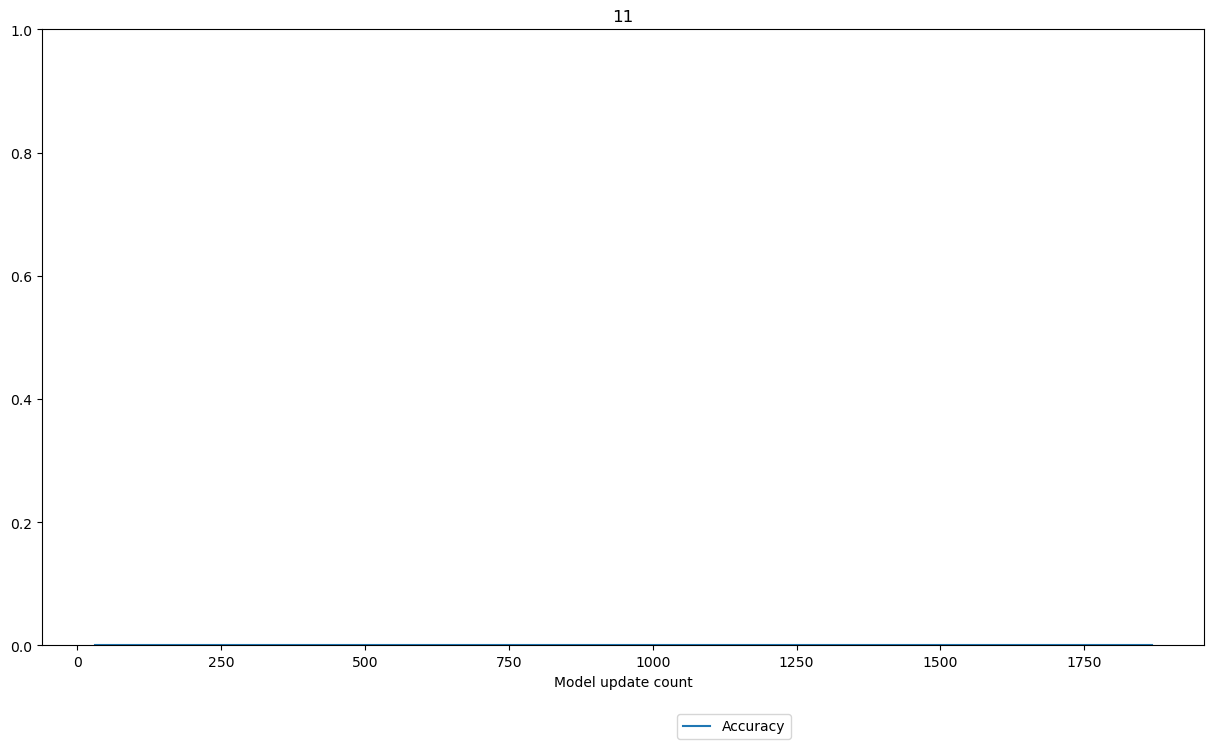

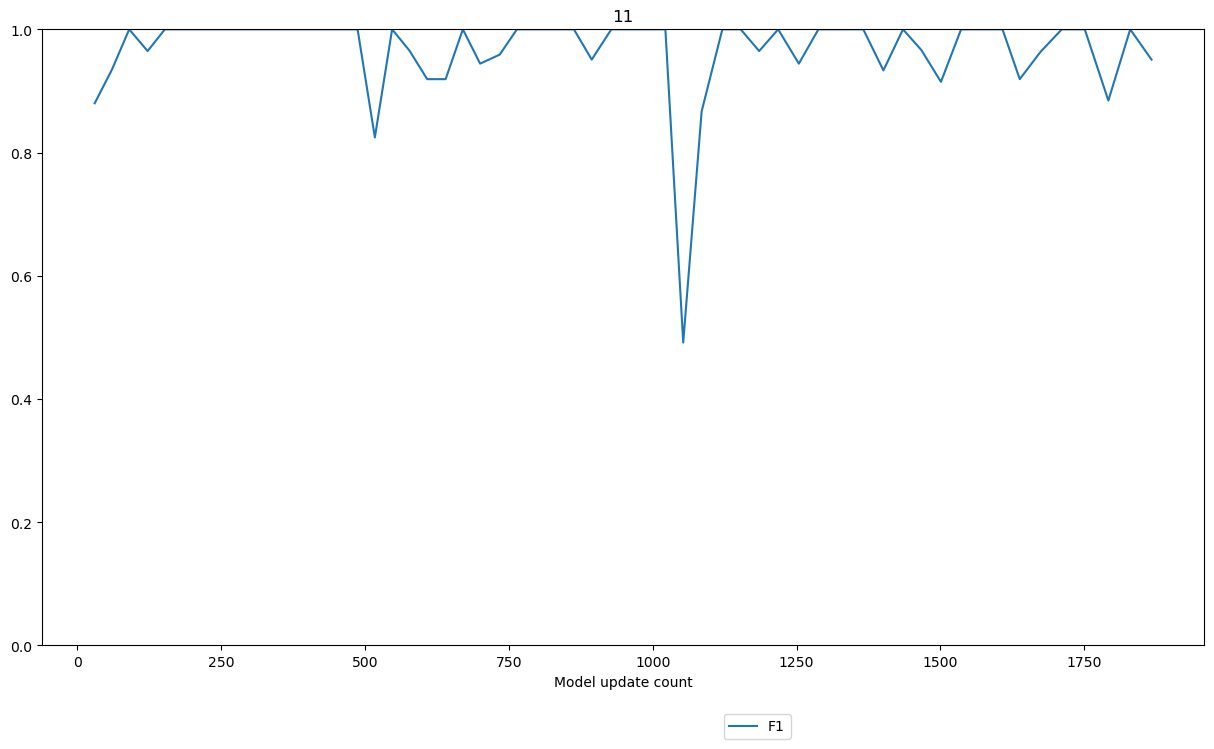

[30, 60, 90, 122, 152, 182, 213, 243, 273, 304, 334, 365, 396, 426, 456, 487, 517, 547, 577, 608, 640, 670, 700, 734, 764, 795, 831, 863, 894, 928, 958, 989, 1022, 1053, 1085, 1121, 1153, 1185, 1218, 1254, 1288, 1326, 1366, 1401, 1435, 1467, 1501, 1536, 1572, 1608, 1638, 1674, 1711, 1751, 1792, 1830, 1867]
12
[35, 69, 110, 150, 187, 228, 266, 308, 347, 394, 429, 475, 509, 543, 578, 621, 655, 688, 731, 771, 815, 855, 893, 943, 981, 1028, 1072, 1118, 1158, 1203, 1247, 1302, 1348, 1407, 1448, 1500, 1555, 1604, 1656, 1707, 1759, 1813, 1863]
[35, 69, 110, 150, 187, 228, 266, 308, 347, 394, 429, 475, 509, 543, 578, 621, 655, 688, 731, 771, 815, 855, 893, 943, 981, 1028, 1072, 1118, 1158, 1203, 1247, 1302, 1348, 1407, 1448, 1500, 1555, 1604, 1656, 1707, 1759, 1813, 1863]


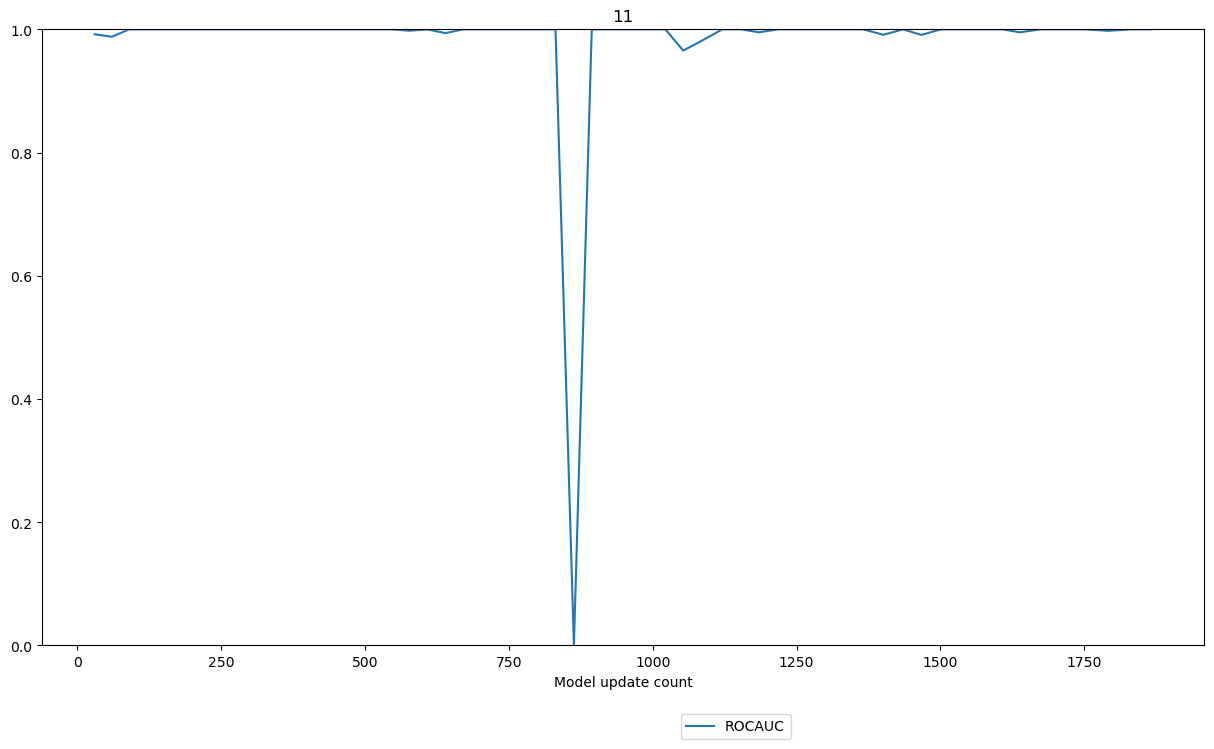

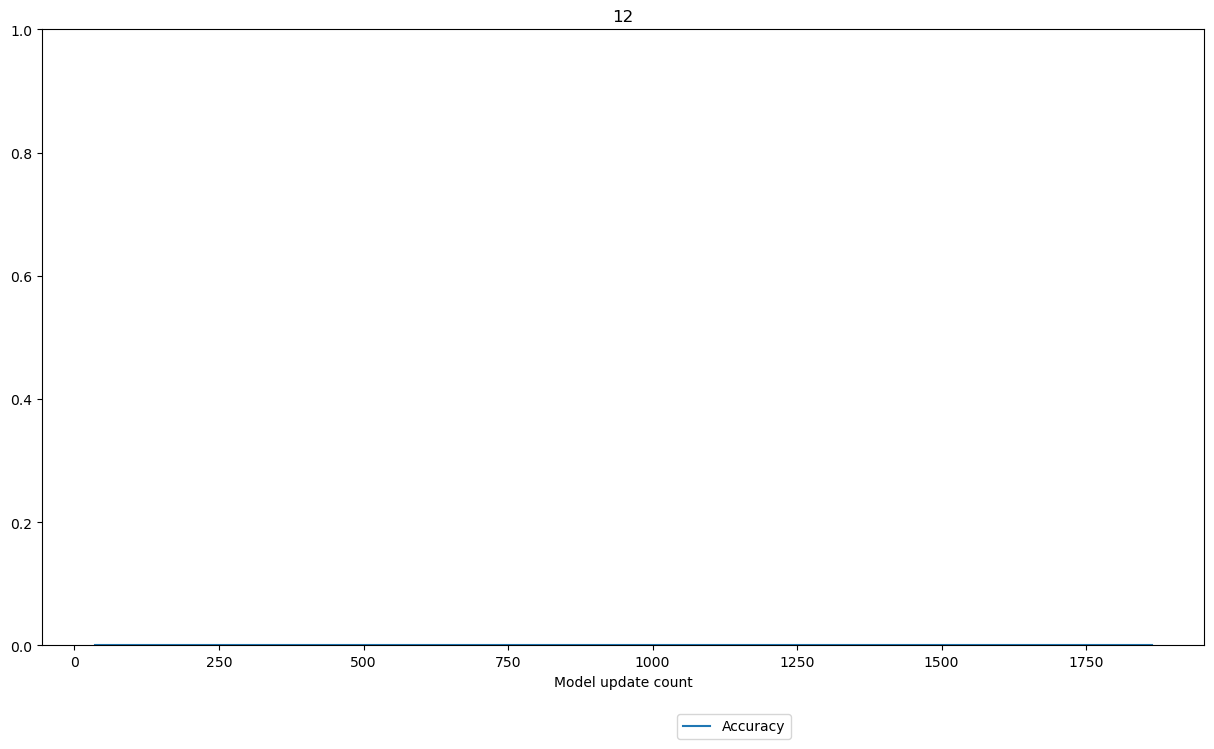

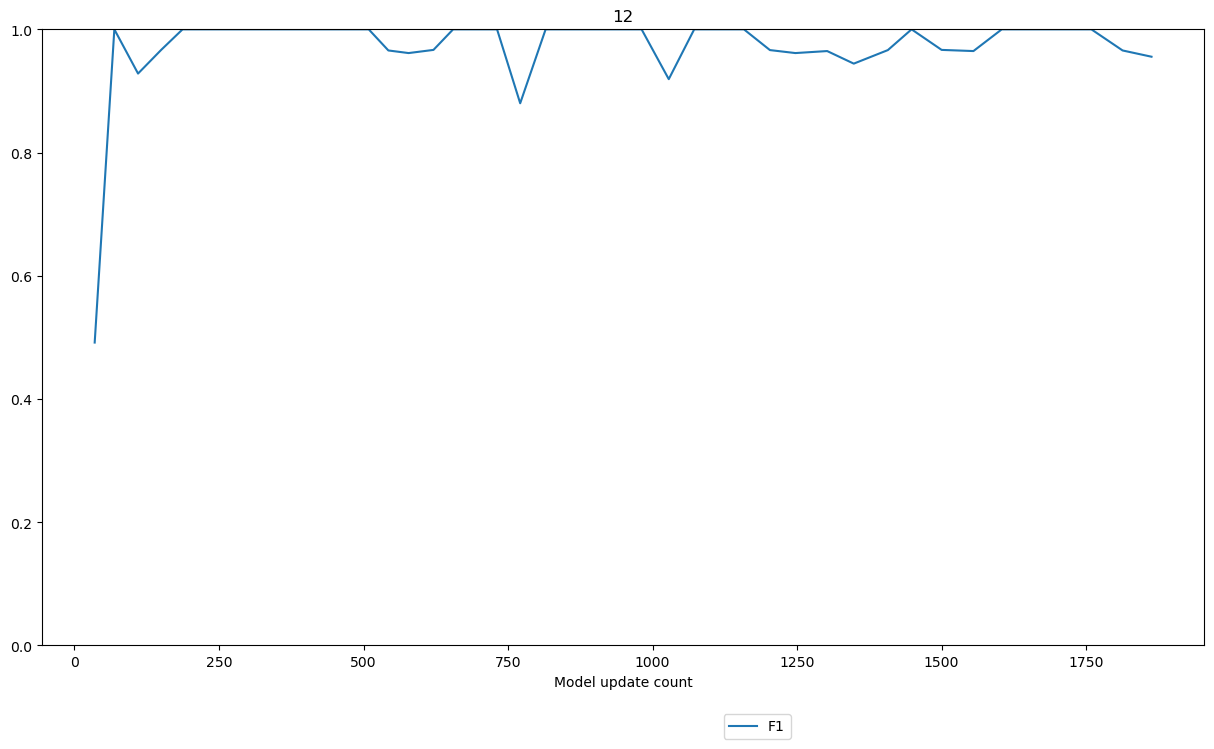

[35, 69, 110, 150, 187, 228, 266, 308, 347, 394, 429, 475, 509, 543, 578, 621, 655, 688, 731, 771, 815, 855, 893, 943, 981, 1028, 1072, 1118, 1158, 1203, 1247, 1302, 1348, 1407, 1448, 1500, 1555, 1604, 1656, 1707, 1759, 1813, 1863]
13
[36, 73, 141, 210, 263, 349, 414, 485, 516, 561, 626, 670, 774, 883, 965, 1072, 1157, 1244, 1359, 1463, 1560, 1659, 1752, 1854]
[36, 73, 141, 210, 263, 349, 414, 485, 516, 561, 626, 670, 774, 883, 965, 1072, 1157, 1244, 1359, 1463, 1560, 1659, 1752, 1854]


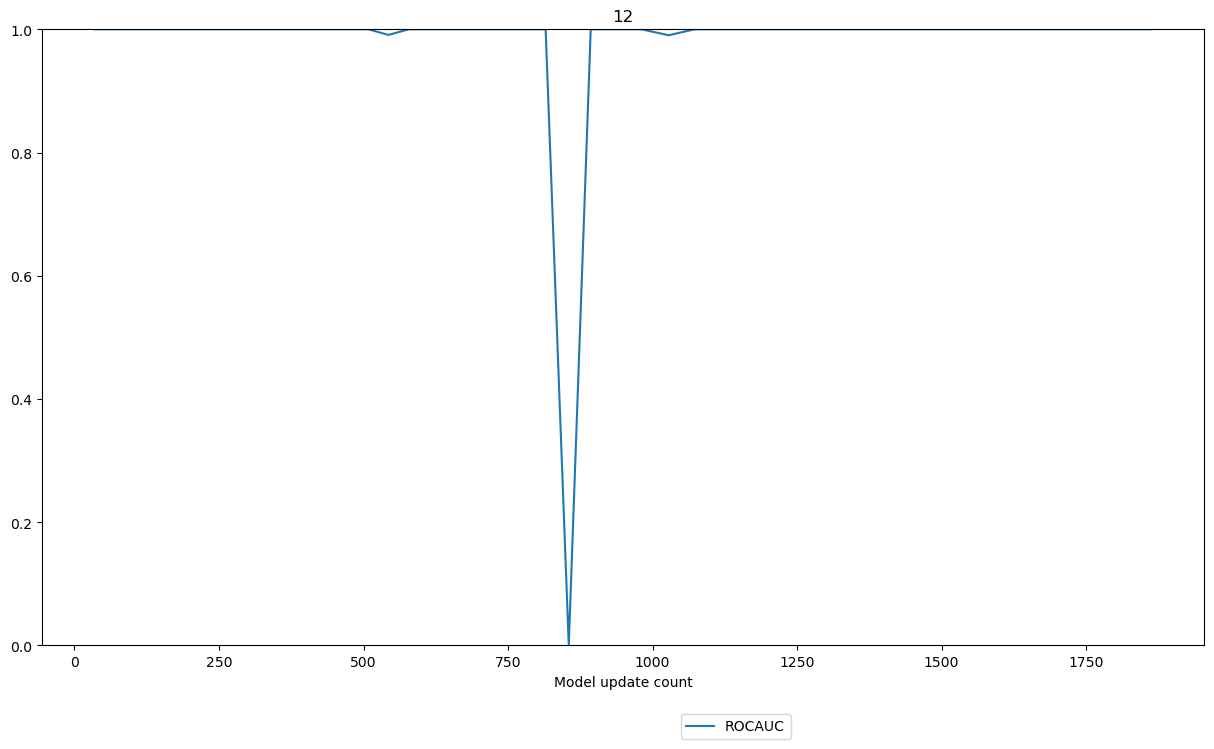

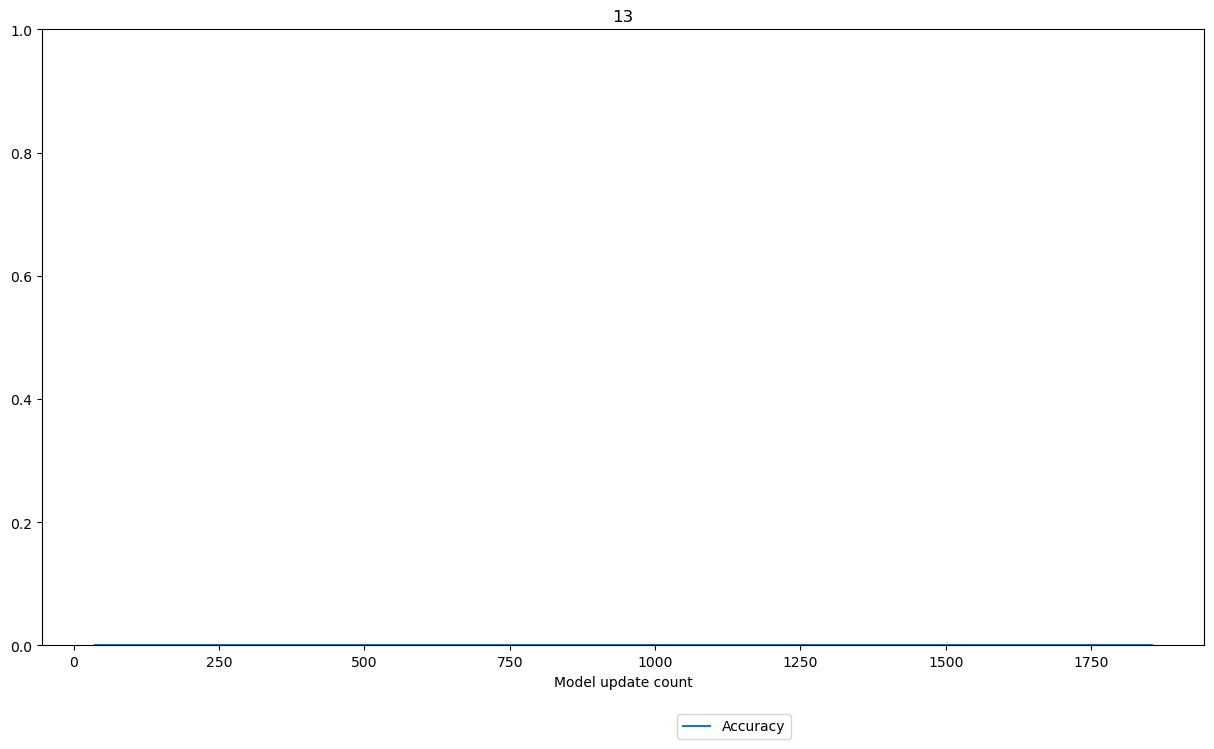

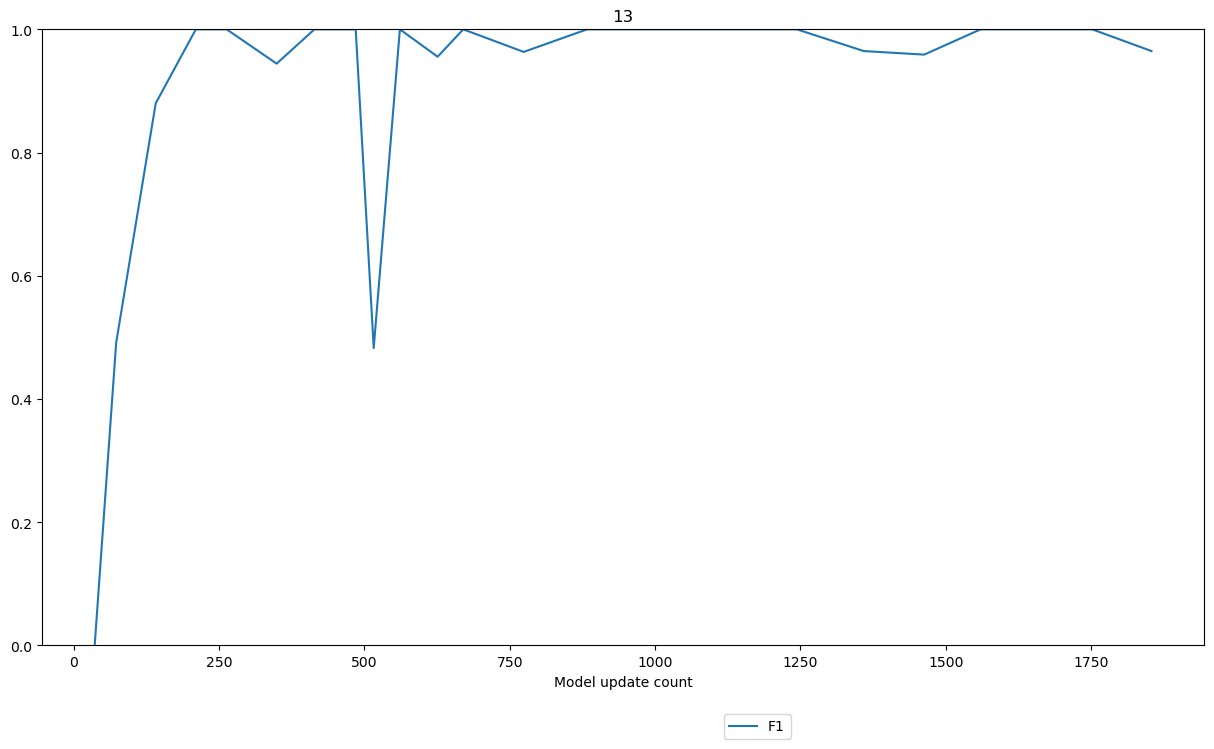

[36, 73, 141, 210, 263, 349, 414, 485, 516, 561, 626, 670, 774, 883, 965, 1072, 1157, 1244, 1359, 1463, 1560, 1659, 1752, 1854]
14
[76, 218, 389, 499, 580, 703, 937, 1217, 1450, 1680]
[76, 218, 389, 499, 580, 703, 937, 1217, 1450, 1680]


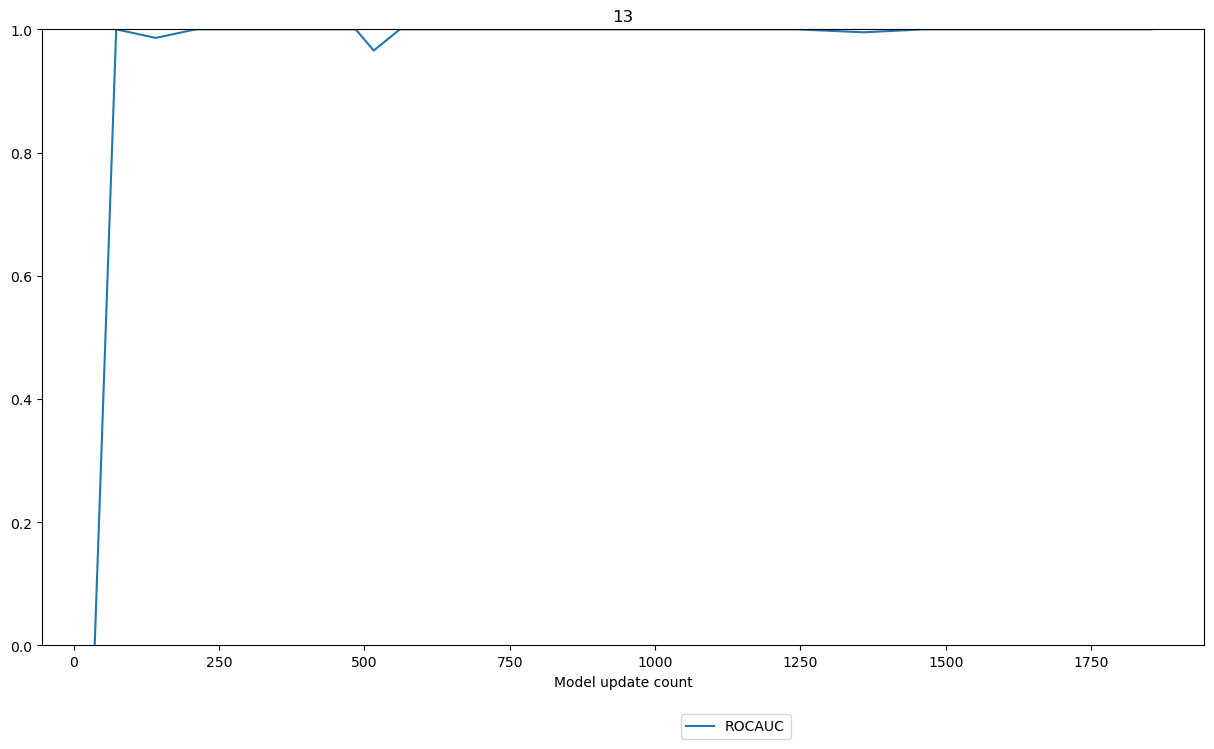

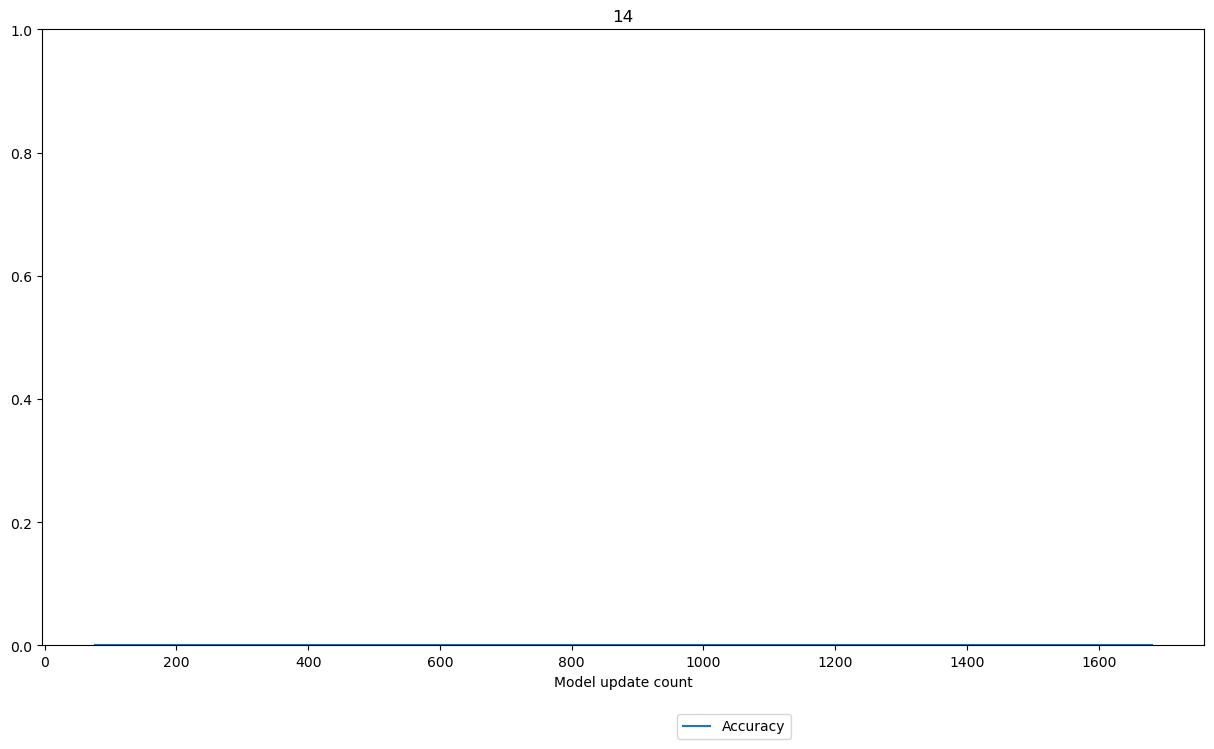

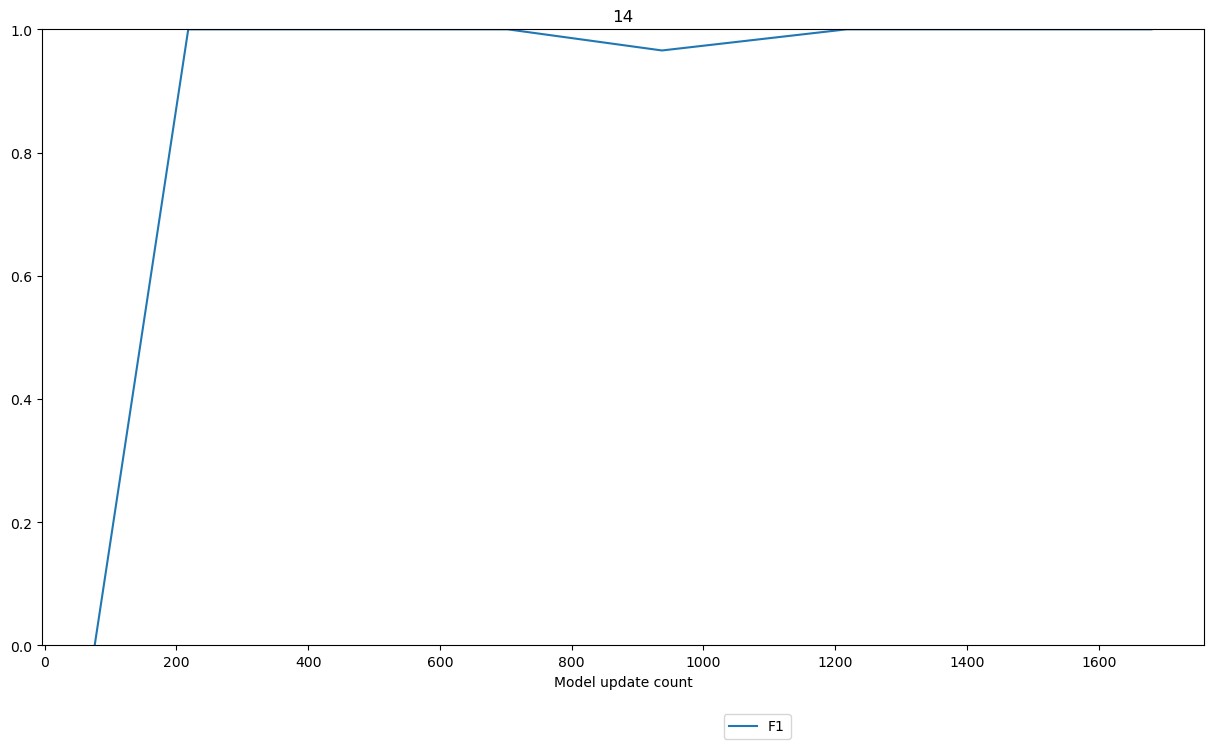

[76, 218, 389, 499, 580, 703, 937, 1217, 1450, 1680]
15
[591, 1237]
[591, 1237]


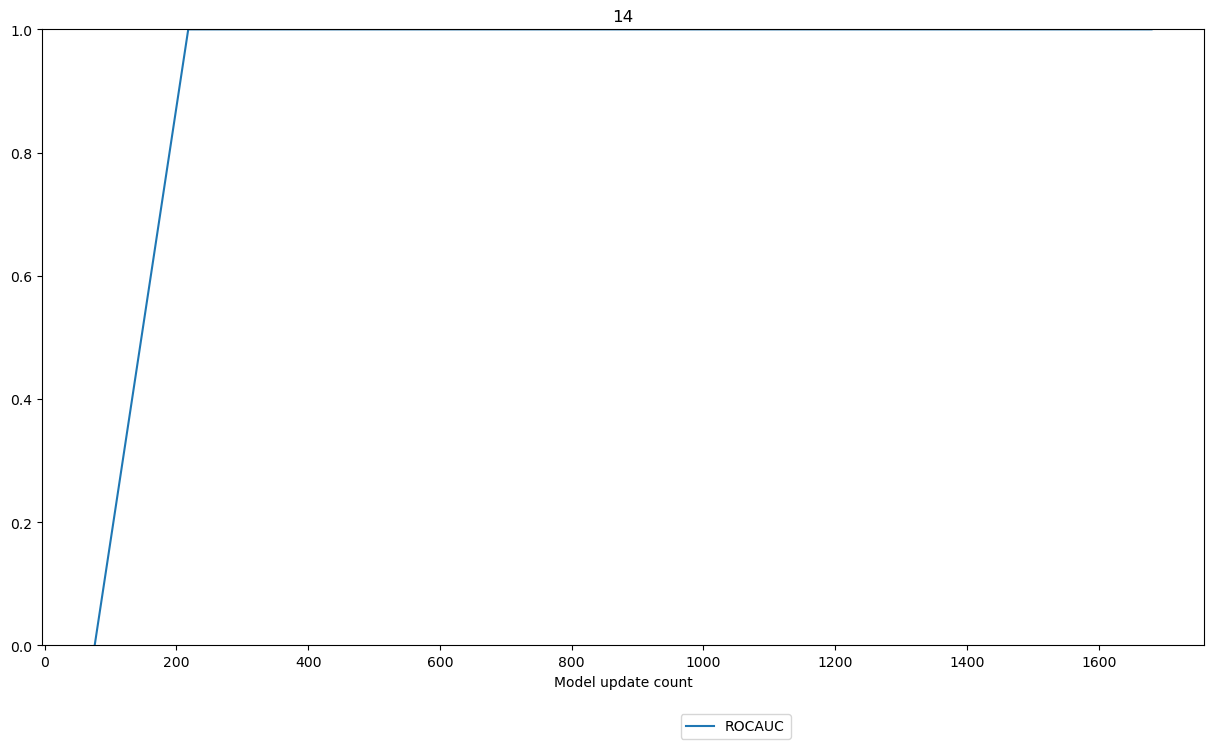

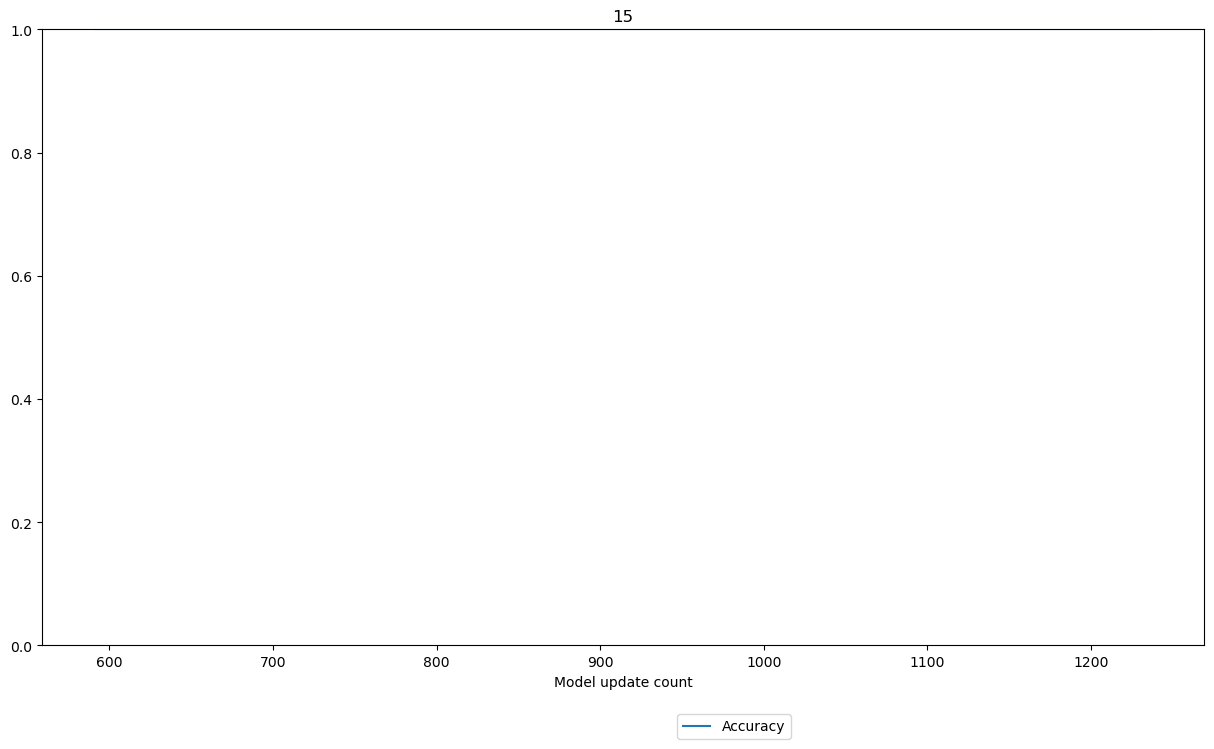

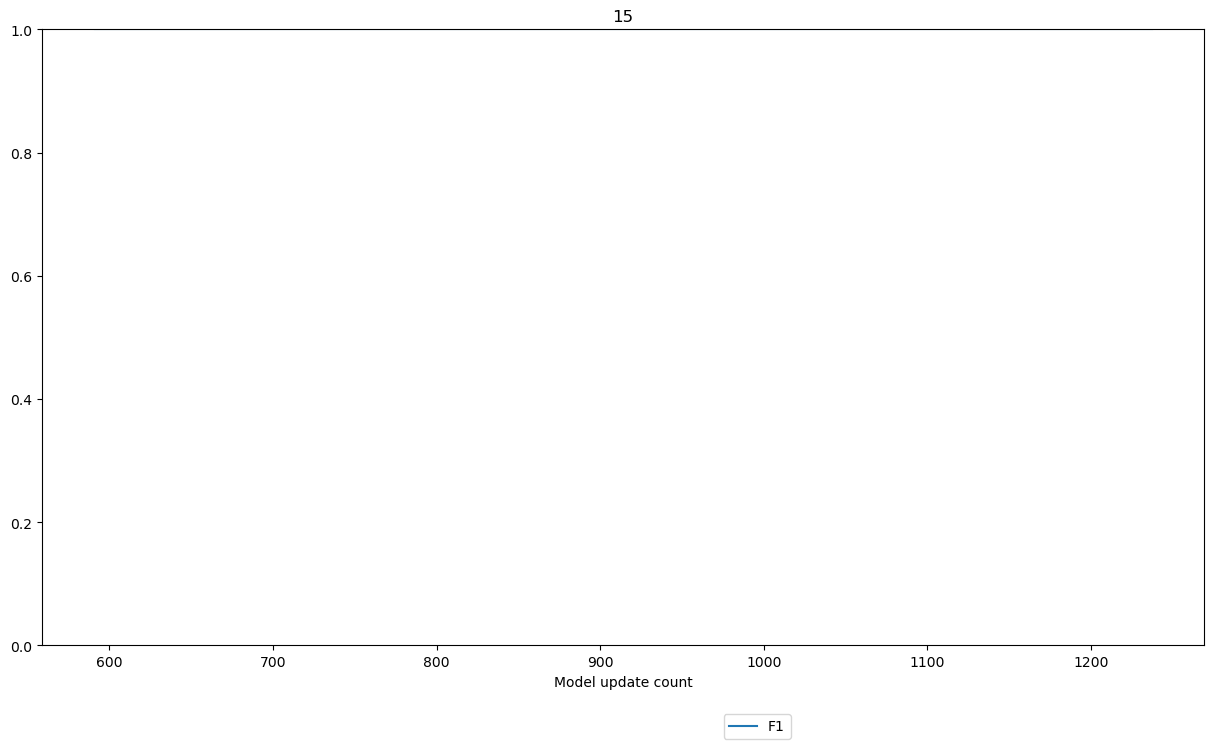

[591, 1237]


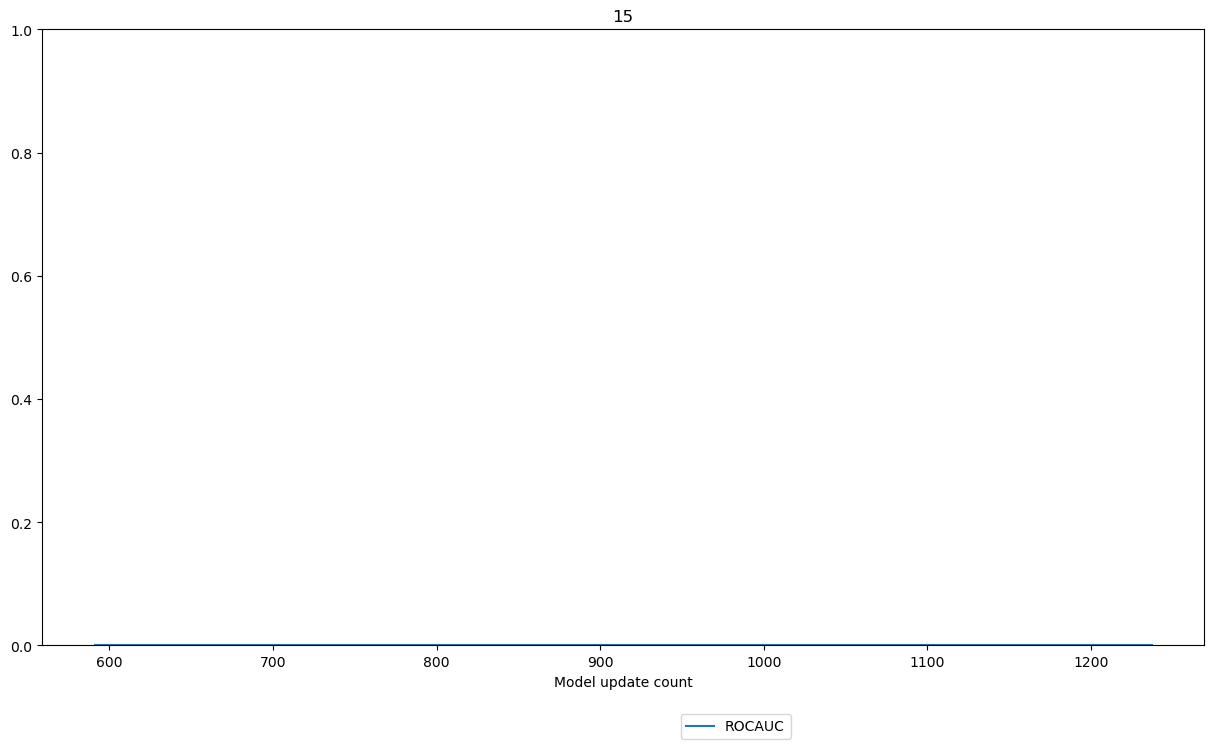

In [49]:
'''
Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
and obtain feature matrix to transform future events
'''



for maximum_prefix in range(1, maximum_prefixs+1):
    print(maximum_prefix)
    performance_measure_type = 'Accuracy'

    dataset_loc = '../DATA/logs/'+ dataset_label +'.csv'
    try:
        os.makedirs('../result/%s'%(dataset_label))
    except:
        pass

    # Set streaming classifier
    classifier = 'xgb'
    if classifier == 'xgb':
        streaming_classifier = xgb.XGBClassifier(n_estimators = 100, learning_rate=0.01, verbosity =0)

    streaming_db ={}
    training_models ={}
    test_cases = deque()
    feature_matrix ={}

    casecount = 0
    rowcounter = 0
    running_case = 0
    prediction_result = dict()
    for i in range(1, maximum_prefix+1): prediction_result[i] = {}
    finished_caseid = set()
    
    # Sliding window for training setting
    window_size = 100
    test_size = 30
    training_windows = sliding_window.training_window(window_size,test_size)
    training_models['prefix_%s'%(maximum_prefix)] = [streaming_classifier, 0]
    
    dataset = stream.iter_csv(
            dataset_loc
            )
    totallength = len(list(dataset))


    dataset = stream.iter_csv(
                dataset_loc,
                target='outcome'
                )
    enctype = 'Index-base'
    
    cdhappend ={}
    for i in range(1, maximum_prefix+1): cdhappend[i] = 0

    for x,y in dataset:
        rowcounter +=1
        # Event stream change dictionary keys
        x = utils.dictkey_chg(x, key_pair)

        if dataset_label !='bpic15':
            x['ts'] = x['ts'][:-4]

        x['outcome'] =y 
        # Initialize case by prefix length
        caseid = x['caseid']
        outcome = x['outcome']
    #     progress = x['progress']

        x.pop('caseid')
        x.pop('outcome')

    #     x.pop('progress')

        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(streaming_db.keys()):
            case_bin.set_prefix_length(1)    
            streaming_db[caseid] = []
        elif caseid in finished_caseid:
            pass
        else:
            case_bin.set_prefix_length(len(streaming_db[caseid])+1)
            case_bin.set_prev_enc(streaming_db[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)
        ts = case_bin.event['ts']
        streaming_db[caseid].append(case_bin)
        # Detect label appeared case 
        if outcome != '' and caseid not in finished_caseid:
            for i in streaming_db[caseid]:
                i.update_truelabel(outcome)
            finished_caseid.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1
            # Grace period to collect feature matrix
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(maximum_prefix)]=set()

                case_length = len(streaming_db[caseid])
                if case_length >= maximum_prefix:
                    x = streaming_db[caseid][maximum_prefix-1]
                    training_windows.update_window(x)
                    update_test_cases(streaming_db[caseid], test_cases)

                    if training_windows.retraining_count == test_size:
                        x_training = pd.DataFrame.from_dict([i.encoded for i in training_windows.container])
                        for i in x_training.columns.values: x_training[i] = x_training[i].fillna(0)
                        feature_matrix['prefix_%s'%(maximum_prefix)] = x_training.columns.values
                        y_training = [i.true_label for i in training_windows.container]

                        ## encoder
                        le = LabelEncoder()
                        y_training = le.fit_transform(y_training)
                        
                        training_models['prefix_%s'%(maximum_prefix)][0].fit(x_training, y_training)
                        training_models['prefix_%s'%(maximum_prefix)][1] +=1
                        training_windows.reset_retraining_count()

                        '''
                        Evaluate current model with test cases
                        '''
                        prediction_result[maximum_prefix][casecount] = {}
                        y_truelist = []
                        y_predlist = []
                        for case in test_cases:
                            if len(case) >= maximum_prefix:
                                x = case[maximum_prefix-1]
                                model = training_models['prefix_%s'%(x.prefix_length)][0]
                                current_event = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                                current_event = pd.Series(current_event).to_frame().T
                                y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba(current_event)
                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)

                        prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
                        prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist
                        if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
                            cdhappend[maximum_prefix] = casecount
                            
                            #######################EVAL#######################
####################################################################################################################################                     
    for evaluation_method in ['Accuracy', 'F1', 'ROCAUC']:
        prefix = maximum_prefix
        update_count =[]
        evaluation_list = []
        length_list = []
        for update in prediction_result[prefix].keys():
            y_true = prediction_result[prefix][update]['y_true']
            y_pred_prob_ = prediction_result[prefix][update]['y_pred']
            prediction_class = training_models['prefix_%s'%(maximum_prefix)][0].classes_
            if len(prediction_class) == 1: prediction_class = ['False', 'True']
            y_pred_prob = []
            for i in y_pred_prob_:
                y_pred_prob.append({prediction_class[0]: i[0][0], prediction_class[1]: i[0][1]})
            y_pred = [max(x, key=x.get) for x in y_pred_prob]
            update_count.append(update)

            if evaluation_method =='Accuracy':
                value = accuracy_score(y_true, y_pred)
                
            elif evaluation_method =='F1':
                conv_y_pred = ['True' if pred == 1 else 'False' for pred in y_pred]
                value = f1_score(y_true, conv_y_pred, average='macro')

                
            elif evaluation_method =='ROCAUC':

                try:
                    y_pred_prob = np.array([[x[0], x[1]] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
                except:
                    y_pred_prob = np.array([[x['False'], x['True']] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
            evaluation_list.append(value)
        plt.figure(figsize=(15,8))
        print(update_count)
        plt.plot(update_count, evaluation_list, label = evaluation_method)
        #     plt.plot(update_count, length_list)
        if dataset_label == 'bpic15' or dataset_label == 'bpic17':
            pass
        else:
            plt.axvline(cdhappend[prefix], color = 'black', linestyle ='--', label = 'Concept drift')
        plt.title(prefix)
        plt.xlabel('Model update count')
        plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
        plt.ylim(0,1)

        if os.path.exists('../img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
            os.makedirs('../img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))
        if os.path.exists('../result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
            os.makedirs('../result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))

        #print (prediction_result)

        #with open('../result/%s/%s/Finished cases/prefix_%s_%s update.pkl'%(dataset_label, classifier, prefix, evaluation_method), 'wb') as f:
        #    pkl.dump(prediction_result, f)
        #plt.savefig('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
        #plt.cla()
        #plt.clf()
        #plt.close()
        if evaluation_method == 'F1':
            plt.show()

In [7]:
prediction_result

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}